In [158]:
#ANGES Dataset
import os
import sys
sys.path.insert(1,'/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmarking')
from tpot.tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from test_utils import extract_labels, get_optimizer, create_dirs


import pandas as pd
 # This is done based on the dataset ID.
#dataset = openml.datasets.get_dataset(1164)
#dataset = openml.datasets.get_dataset(1164)
dataset = pd.read_csv("/Users/matsumoton/Documents/anges_cad_1_train.csv",sep=",")
y_train = dataset['target']
X_train = dataset.drop(['target'],axis=1)

test_dataset = pd.read_csv("/Users/matsumoton/Documents/anges_cad_1_test.csv",sep=",")
y_test = test_dataset['target']
X_test = test_dataset.drop(['target'],axis=1)


In [159]:
#best pareto front pipelines
#plotting

from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import statistics


#directoryevs = ["/baseline_gen100/baseline_gen100","/lexicase_gen100/lexicase_gen100","/epsbestlexicase_gen100/epsbestlexicase"]
directoryevs = ["/baseline_gen100/baseline_gen100","/epsbestlexicase_gen100/epsbestlexicase"]
upper_quantile_only = False

generation_num = 99
total_runs = 50

name_values = {
    "/baseline/baseline" : "NSGA-II",
    "/baseline_dynamic/baseline_dynamic" : "baseline_dynamic",
    "/lexicase/lexicase" : "lexicase",
    "/lexicase_dynamic/lexicase_dynamic" : "lexicase_dynamic",
    "/baseline_gen100/baseline_gen100" : "NSGA-II",
    "/lexicase_gen100/lexicase_gen100" : "Lexicase",
    "/selbest/selbest" : "selbest",
    "/epsbestlexicase_gen100/epsbestlexicase" : "Lexicase",
    #"/epsbestlexicase_gen100/epsbestlexicase" : "Automatic Epsilon Lexicase",
    #"/epsbestlexicase_gen100/epsbestlexicase" : "\u03B5-Best"
}

key_times = [0,1,2,3,5,8,10,15,20,30,40,50,60,70,80,90,100 ]

ev = []
for directoryev in directoryevs:
    temp_ev = [] 
    for i in range(total_runs):
        ev_df_name = f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/anges{directoryev}_{i}_pareto_fitness.csv"
        #ev_df_name = f"/Users/matsumoton/pareto/anges{directoryev}_{i}_pareto_fitness.csv"
        #ev_df_name = f"/Users/matsumoton/Git/results_pop40_gen20_{directoryev}/pareto_fitnesses/digen{j}_run_{i}_evolution_pop40_gen20.csv"
        if not exists(ev_df_name):
            continue
        fitness_df = pd.read_csv(ev_df_name, sep=',')
        fitness_df = fitness_df[~fitness_df.isin([np.nan, np.inf, -np.inf]).any(1)]
        temp_ev.append(fitness_df)

    temp_ev = pd.concat(temp_ev)
    temp_ev["type"] = name_values[directoryev]
    
    temp_ev["score_diff"] = abs(temp_ev["cv_score"]-temp_ev["holdout_score"])
    ev.append(temp_ev)

frame_df = pd.concat(ev)
frame_df = frame_df[~frame_df.isin([np.nan, np.inf, -np.inf]).any(1)]


In [160]:
#prints out top pipelines across all runs based on pareto front
bestpipelines = []
for directoryev in directoryevs:
    tempdf = frame_df[frame_df["type"] == name_values[directoryev]]
    tempdf = tempdf.reset_index()
    #print(name_values[directoryev])
    #print(tempdf.iloc[tempdf['cv_score'].idxmax()])
    
    tempdf = tempdf[tempdf.groupby(['generation'],sort=False)['cv_score'].transform(max) == tempdf['cv_score']]
    tempdf = tempdf.sort_values(by="generation")
    #print(tempdf)
    bestpipelines.append(tempdf)
bestpipelines = pd.concat(bestpipelines)
bestpipelines = bestpipelines.reset_index()

In [181]:
#evaluate the pipelines to get the respective confidence intervals
from deap import creator
import deap
tpot = TPOTClassifier(verbosity=2, population_size=1, generations=1,test_x = X_test, test_y = y_test, scoring="balanced_accuracy", cv=10, dynamic_rates = True)
tpot.fit(X_train, y_train)

bestpipelines["upper_ci_holdout"] = 0
bestpipelines["lower_ci_holdout"] = 0
bestpipelines["operator_count"] = 0


prev_pipeline = ''
p = s = op = 0
for k in range(bestpipelines.shape[0]):
    print(k)
    pipeline = bestpipelines["pipeline"][k]
    if prev_pipeline == pipeline:
        bestpipelines["upper_ci_holdout"][k] = p+1.96*s
        bestpipelines["lower_ci_holdout"][k] = p-1.96*s
        bestpipelines["operator_count"][k] = op
        bestpipelines["holdout_score"][k] = p
        continue
    prev_pipeline = pipeline
    #print(pipeline)

    test = creator.Individual.from_string(pipeline, tpot._pset)
    #print(test)
    
    pipeline_fitted = tpot._toolbox.compile(expr=test)
    pipeline_fitted.fit(X_train, y_train)

    operator_count = 0
    for node in test:
        if type(node) is deap.gp.Primitive and node.name != "CombineDFs":
            operator_count += 1

    predictions = pipeline_fitted.predict(X_test)
    p = sum(pipeline_fitted.predict(X_test) == y_test)/len(y_test)
    s = np.sqrt(p*(1-p)/len(y_test))
    op = operator_count
    #predictions = pipeline_fitted.predict(X_train)
    #p = sum(pipeline_fitted.predict(X_train) == y_train)/len(y_train)
    #s = np.sqrt(p*(1-p)/len(y_train))
    bestpipelines["holdout_score"][k] = p
    bestpipelines["upper_ci_holdout"][k] = p+1.96*s
    bestpipelines["lower_ci_holdout"][k] = p-1.96*s
    bestpipelines["operator_count"][k] = operator_count

Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5

Best pipeline: MLPClassifier(input_matrix, alpha=0.01, learning_rate_init=0.5)
0


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

1


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

2
3


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:44: SettingWithCopyWarning: 
A value is t

4
5


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

6
7


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MaxAbsScaler was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MaxAbsScaler was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature n

39
40
41


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifi

42
43
44
45
46
47
48


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:44: SettingWithCopyWarning: 
A value is t

49
50
51
52
53
54


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have

55


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have val

56
57
58


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have

59
60
61
62
63


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

104


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

105


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

106
107
108
109
110
111
112
113


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [3] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not h

114
115
116
117


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pan

118
119
120
121


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

122
123


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not h

124
125
126
127
128


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

129
130


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

131
132


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

133
134
135
136


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3393861394.py:44: SettingWithCopyWarning: 
A value is trying to be set 

In [100]:
bestpipelines


level_0  index                                           pipeline  \
0          1      1  MultinomialNB(RFE(input_matrix, RFE__ExtraTree...   
1          3      3  MultinomialNB(RFE(input_matrix, RFE__ExtraTree...   
2          5      5  MultinomialNB(RFE(input_matrix, RFE__ExtraTree...   
3       4524     10  MultinomialNB(RandomForestClassifier(DecisionT...   
4       4527     13  MultinomialNB(RandomForestClassifier(DecisionT...   
..       ...    ...                                                ...   
200     9560    319  XGBClassifier(GradientBoostingClassifier(Selec...   
201     9564    323  XGBClassifier(GradientBoostingClassifier(Selec...   
202     9568    327  XGBClassifier(GradientBoostingClassifier(Selec...   
203     9572    331  XGBClassifier(GradientBoostingClassifier(Selec...   
204     9576    335  XGBClassifier(GradientBoostingClassifier(Selec...   

     cv_score  generation  holdout_score  holdout_roc_auc_score  \
0    0.788277           0       0.719828               0.801027   
1    0.798474           1       0.719828               0.798562   
2    0.798474           2       0.719828               0.800205   
3    0.799938           3       0.715517               0.787365   
4    0.799938           4       0.715517               0.788803   
..        ...         ...            ...                    ...   
200  0.833694          96       0.750000               0.760812   
201  0.833694          97       0.750000               0.768002   
202  0.833694          98       0.750000               0.771803   
203  0.833694          99       0.750000               0.762969   
204  0.833694         100       0.750000               0.773909   

                           type  score_diff  upper_ci_holdout  \
0                       NSGA-II    0.049910          0.777616   
1                       NSGA-II    0.072023          0.777616   
2                       NSGA-II    0.075464          0.777616   
3                       NSGA-II    0.111084          0.773574   
4                       NSGA-II    0.101993          0.773574   
..                          ...         ...               ...   
200  Automatic Epsilon Lexicase    0.106884          0.805720   
201  Automatic Epsilon Lexicase    0.101234          0.805720   
202  Automatic Epsilon Lexicase    0.115975          0.805720   
203  Automatic Epsilon Lexicase    0.113150          0.805720   
204  Automatic Epsilon Lexicase    0.104675          0.805720   

     lower_ci_holdout  operator_count  
0            0.662039               2  
1            0.662039               2  
2            0.662039               2  
3            0.657461               3  
4            0.657461               3  
..                ...             ...  
200          0.694280               4  
201          0.694280               4  
202          0.694280               4  
203          0.694280               4  
204          0.694280               4  

[205 rows x 12 columns]

In [86]:
for directoryev in directoryevs:
    tempdf = bestpipelines[bestpipelines["type"] == name_values[directoryev]]
    tempdf = tempdf.reset_index()
    #print(name_values[directoryev])
    print(tempdf.iloc[tempdf['cv_score'].idxmax()])
    

ValueError: cannot insert level_0, already exists

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


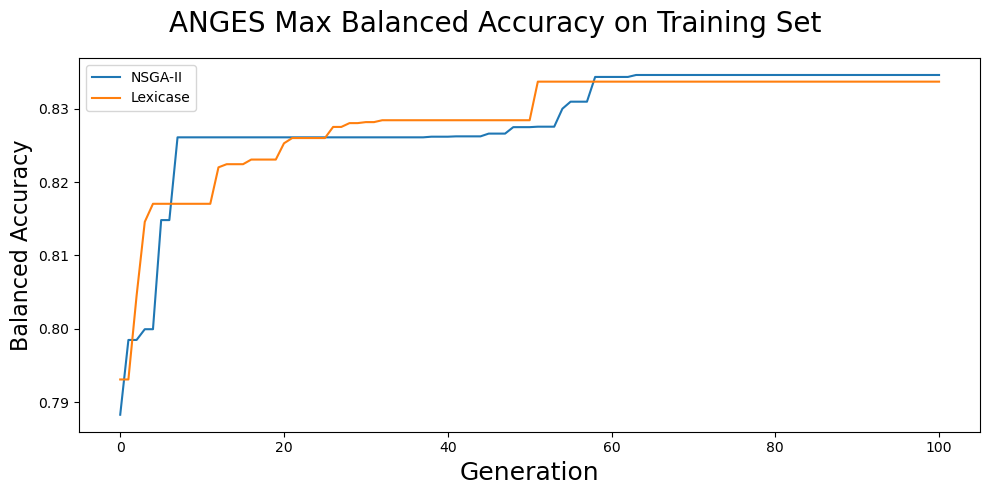

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


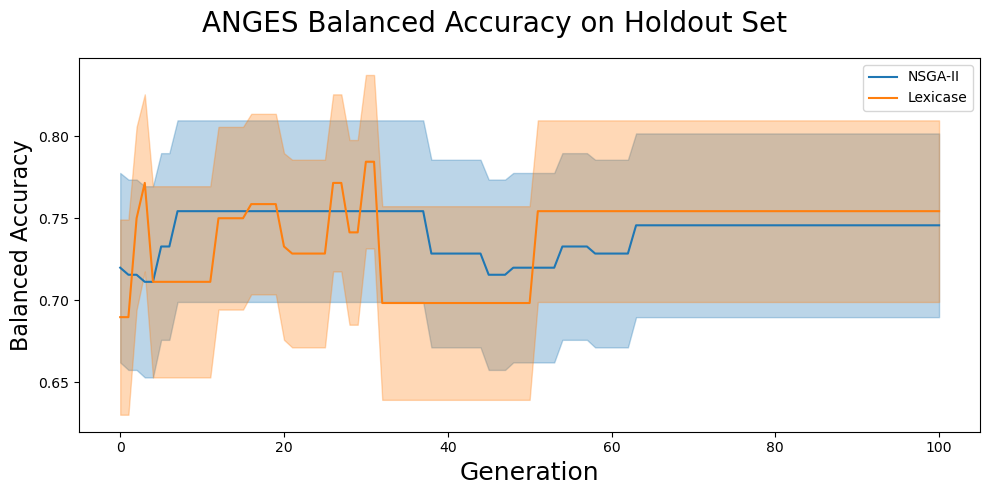

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


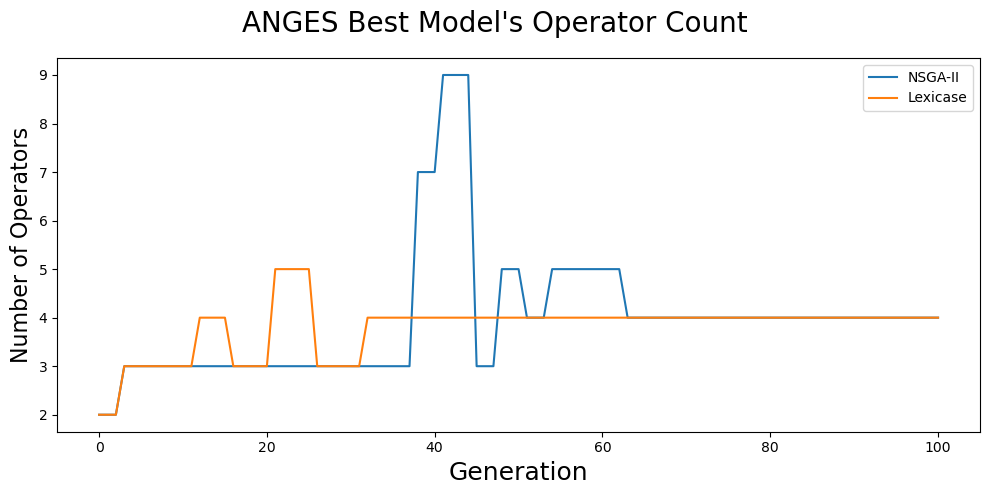

In [182]:

plt.rcParams["figure.figsize"] = (10,5)

fig = plt.figure()
seaborn.lineplot(x="generation",y="cv_score",hue="type",data=bestpipelines, 
estimator=np.max,label = "type" if i == 0 else "")#.set(title="Anges Max Balanced Accuracy on Training Set")
fig.suptitle('ANGES Max Balanced Accuracy on Training Set', fontsize=20)
plt.ylabel("Balanced Accuracy",fontsize=16)
plt.xlabel('Generation', fontsize=18)
plt.gca().legend().set_title('')
plt.savefig(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/final_plots_autoeps/anges_pareto_max_training_set_full1.png")
plt.show()

fig = plt.figure()
seaborn.lineplot(x="generation",y="holdout_score",hue="type",data=bestpipelines, 
estimator=np.median,label = "type" if i == 0 else "")#.set(title="Anges Balanced Accuracy on Holdout Score")
color_counter = 0
for directoryev in directoryevs:
    tempdf = bestpipelines[bestpipelines["type"] == name_values[directoryev]]
    plt.fill_between(tempdf["generation"],tempdf["upper_ci_holdout"],tempdf["lower_ci_holdout"],color='C' + str(color_counter),alpha=0.3)
    color_counter = color_counter + 1
fig.suptitle('ANGES Balanced Accuracy on Holdout Set', fontsize=20)
plt.ylabel("Balanced Accuracy",fontsize=16)
plt.xlabel('Generation', fontsize=18)
plt.gca().legend().set_title('')
plt.savefig(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/final_plots_autoeps/anges_pareto_max_holdout_set_full1.png")
plt.show()


fig = plt.figure()
seaborn.lineplot(x="generation",y="operator_count",hue="type",data=bestpipelines, label = "type" if i == 0 else "")#.set(title="Anges Best Model's Operator Count")
fig.suptitle("ANGES Best Model's Operator Count", fontsize=20)
plt.ylabel("Number of Operators",fontsize=16)
plt.xlabel('Generation', fontsize=18)
plt.gca().legend().set_title('')
plt.savefig(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/final_plots_autoeps/anges_pareto_operator_count1.png")
plt.show()

    


replot



digen 24

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


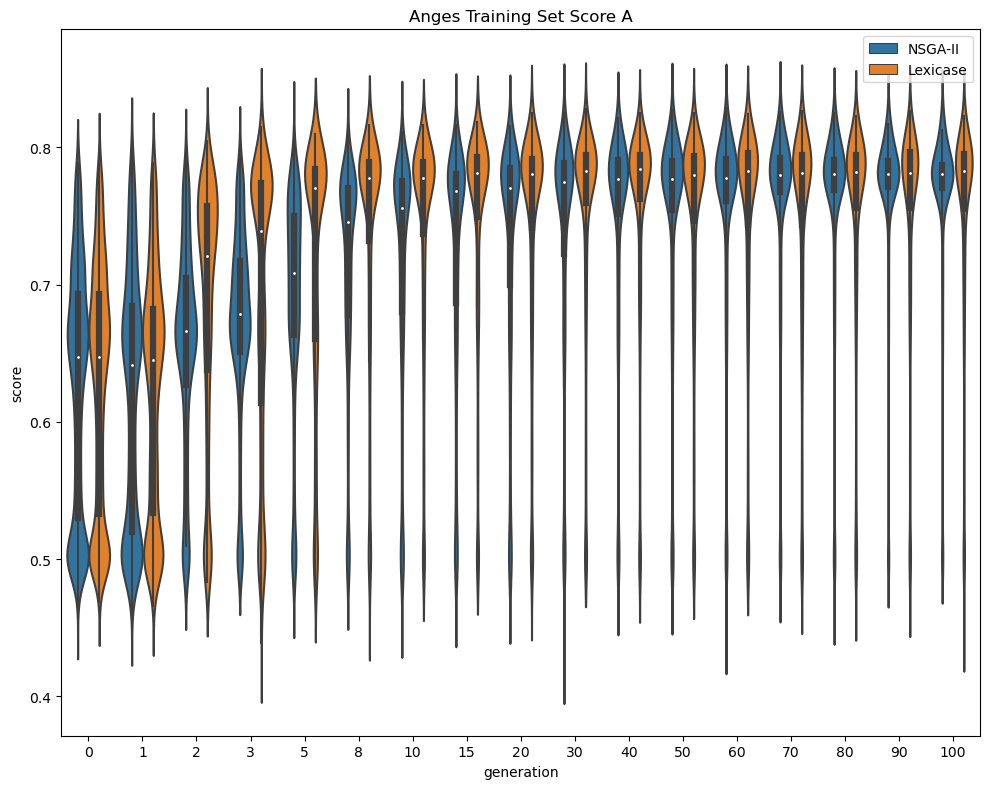

'\noperator count table\nfor directoryev in directoryevs:\n    print(directoryev)\n    for i in range(0,generation_num):\n        print(str(i) + \' \' + str(np.mean(frame_df.loc[(frame_df[\'generation\']==i) & (frame_df["type"] == directoryev),\'operator_count\'])) + \' \' + str(np.median(frame_df.loc[(frame_df[\'generation\']==i) & (frame_df["type"] == directoryev),\'operator_count\'])))\n'

In [137]:
#violin plots per generation

from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import statistics
import pandas as pd

upper_quantile_only = False

generation_num = 99
total_runs = 50

#key_times = [0,1,2,3,5,8,10,15,20,30,40,50,60,70,80,90,99 ]
key_times = [0,1,2,3,5,8,10,15,20,30,40,50,60,70,80,90,100 ]

ev = []
for directoryev in directoryevs:
    temp_ev = []
    for i in range(total_runs):
        ev_df_name = f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/anges{directoryev}_{i}_fitness.csv"
        if not exists(ev_df_name):
            continue
        fitness_df = pd.read_csv(ev_df_name, sep=',')
        fitness_df = fitness_df[~fitness_df.isin([np.nan, np.inf, -np.inf]).any(1)]
        if upper_quantile_only:
            high_quantile= []
            for g in range(0,generation_num):
                upper_quantile = np.quantile(fitness_df.loc[fitness_df['generation']==g,'score'],0.99)
                high_quantile.append(fitness_df.loc[(fitness_df['generation']==g) & (fitness_df['score'] >= upper_quantile)])
            fitness_df = pd.concat(high_quantile)
        fitness_df = fitness_df[fitness_df["generation"].isin(key_times)]
        temp_ev.append(fitness_df)

    temp_ev = pd.concat(temp_ev)
    temp_ev["type"] = name_values[directoryev]
    
    ev.append(temp_ev)
frame_df = pd.concat(ev)
frame_df = frame_df[~frame_df.isin([np.nan, np.inf, -np.inf]).any(1)]
seaborn.violinplot(x="generation",y="score",hue="type",data=frame_df, label = "type" if i == 0 else "").set(title="Anges Training Set Score A")
plt.legend()

plt.savefig(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/final_plots_autoeps/anges_pipelines.png")
plt.show()

'''
operator count table
for directoryev in directoryevs:
    print(directoryev)
    for i in range(0,generation_num):
        print(str(i) + ' ' + str(np.mean(frame_df.loc[(frame_df['generation']==i) & (frame_df["type"] == directoryev),'operator_count'])) + ' ' + str(np.median(frame_df.loc[(frame_df['generation']==i) & (frame_df["type"] == directoryev),'operator_count'])))
'''


In [157]:

ev = []
for directoryev in directoryevs:
    temp_ev = [] 
    for i in range(total_runs):
        ev_df_name = f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/digen/results_pop40_gen20_{directoryev}/pipelines/digen{j}_run_{i}_metrics.csv"
        #ev_df_name = f"/Users/matsumoton/pareto/anges{directoryev}_{i}_pareto_fitness.csv"
        #ev_df_name = f"/Users/matsumoton/Git/results_pop40_gen20_{directoryev}/pareto_fitnesses/digen{j}_run_{i}_evolution_pop40_gen20.csv"
        if not exists(ev_df_name):
            continue
        fitness_df = pd.read_csv(ev_df_name, sep=',')
        fitness_df = fitness_df[~fitness_df.isin([np.nan, np.inf, -np.inf]).any(1)]
        fitness_df = fitness_df.append(fitness_df[2:3])
        fitness_df.iloc[[5],[0]] = "adjusted_ge"
        fitness_df.iloc[[5],1:] = fitness_df.iloc[[2],1:].astype(float) / fitness_df.iloc[[0],1:].astype(float).values

        fitness_df = fitness_df.append(fitness_df[2:3])
        fitness_df.iloc[[6],[0]] = "leaf_node_ratio"
        fitness_df.iloc[[6],1:] = fitness_df.iloc[[3],1:].astype(float) / fitness_df.iloc[[0],1:].astype(float).values

        fitness_df = fitness_df.reset_index()
        temp_ev.append(fitness_df.iloc[[0,1,2,3,5,6]])

    temp_ev = pd.concat(temp_ev)
    temp_ev["type"] = name_values[directoryev]
    
    #temp_ev["score_diff"] = abs(temp_ev["cv_score"]-temp_ev["holdout_score"])
    ev.append(temp_ev)

frame_df = pd.concat(ev)
frame_df = frame_df.drop('index',axis=1)
frame_df = frame_df.rename(columns={'Unnamed: 0': 'score'})
frame_df = (frame_df.melt(['score','type'], var_name='generation')
        #.assign(Date = lambda x: pd.to_datetime(x['Date'], format='%d.%m.%Y'))
        .reset_index()
        )

frame_df = frame_df[frame_df["type"].isin(['NSGA-II','Lexicase','Automatic Epsilon Lexicase'])]
#frame_df = frame_df[frame_df["generation"].astype(int).isin(key_times)]

df = frame_df[frame_df["score"] == "adjusted_ge"]

df["value"] = df["value"].astype(float)
df["log_value"] = np.log(df["value"])
seaborn.lineplot(x="generation",y="log_value",hue="type",data=df, 
#errorbar="sd",
estimator=np.median,label = "type" if i == 0 else "").set(title="Median ANGES Nodal Global Efficiency from Root")
plt.ylabel("Logarithmic Nodal Global Efficiency")


plt.savefig(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/final_plots_autoeps/anges_pareto_median_nodal_global_eff.png")

plt.show()
df = frame_df[frame_df["score"] == "unique_nodes"]
df["value"] = df["value"].astype(int)
seaborn.lineplot(x="generation",y="value",hue="type",data=df, 
#errorbar="sd",
estimator=np.max,label = "type" if i == 0 else "").set(title="Median ANGES Unique Nodes")
plt.ylabel("Number of Unique Nodes")
plt.savefig(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/final_plots_autoeps/anges_pareto_median_unique_nodes.png")
plt.show()

df = frame_df[frame_df["score"] == "exploratory_metric"]
df["value"] = df["value"].astype(float)
seaborn.lineplot(x="generation",y="value",hue="type",data=df, 
#errorbar="sd",
estimator=np.median,label = "type" if i == 0 else "").set(title="Median ANGES Exploratory Metric")
plt.ylabel("Non-normalized Nodal Global Efficiency")
plt.savefig(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/final_plots_autoeps/anges_pareto_median_exploratory_met.png")
plt.show()

df = frame_df[frame_df["score"] == "leaf_node_ratio"]
df["value"] = df["value"].astype(float)
seaborn.lineplot(x="generation",y="value",hue="type",data=df, 
#errorbar="sd",
estimator=np.median,label = "type" if i == 0 else "").set(title="Median ANGES Leaf Node Ratio")
plt.ylabel("Leaf Node Ratio")
plt.savefig(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/final_plots_autoeps/anges_pareto_median_leaf_node_ratio.png")
plt.show() 

ValueError: No objects to concatenate

In [27]:
#unique search space average per generation by operator count using the trie metrics

directoryevs = ["/baseline_gen100/baseline_gen100","/lexicase_gen100/lexicase_gen100","/epsbestlexicase_gen100/epsbestlexicase"]

ev = []
for directoryev in directoryevs:
    temp_ev = [] 
    for i in range(total_runs):
        ev_df_name = f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/anges{directoryev}_{i}_metrics.csv"
        if not exists(ev_df_name):
            print(i)
            continue
        fitness_df = pd.read_csv(ev_df_name, sep=',')
        fitness_df = fitness_df[~fitness_df.isin([np.nan, np.inf, -np.inf]).any(1)]
        temp_ev.append(fitness_df.T)
    
    temp_ev = pd.concat(temp_ev)
    #temp_ev = temp_ev.T
    temp_ev["type"] = name_values[directoryev]
    ev.append(temp_ev)

pareto_metrics = pd.concat(ev)

print(pareto_metrics)

#nonunique evaluation of pipelines per generation
#metrics['unique']

46
47
48
49
                       0                   1                   2  \
Unnamed: 0  unique_nodes   global_efficiency  exploratory_metric   
0                     62  0.6229508196721312                38.0   
1                     86  0.5725490196078433  48.666666666666686   
2                    110  0.5443425076452603   59.33333333333337   
3                    133  0.5214646464646465   68.83333333333334   
...                  ...                 ...                 ...   
96                   850  0.3182287284760772  270.17619047618956   
97                   871  0.3155103995621226   274.4940476190467   
98                   915   0.310087787850369  283.42023809523727   
99                   934  0.3080717603225632   287.4309523809515   
100                  982  0.3032692587738451    297.507142857142   

                           3  \
Unnamed: 0  leafnode_counter   
0                         49   
1                         64   
2                         82   
3          

In [127]:
#best pareto front pipelines
#plotting

from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import statistics


#directoryevs = ["/baseline_gen100/baseline_gen100","/lexicase_gen100/lexicase_gen100","/epsbestlexicase_gen100/epsbestlexicase"]
directoryevs = ["/baseline_gen100/baseline_gen100","/epsbestlexicase_gen100/epsbestlexicase"]
upper_quantile_only = False

generation_num = 100
total_runs = 50

name_values = {
    "/baseline/baseline" : "NSGA-II",
    "/baseline_dynamic/baseline_dynamic" : "baseline_dynamic",
    "/lexicase/lexicase" : "lexicase",
    "/lexicase_dynamic/lexicase_dynamic" : "lexicase_dynamic",
    "/baseline_gen100/baseline_gen100" : "NSGA-II",
    "/lexicase_gen100/lexicase_gen100" : "Lexicase",
    "/selbest/selbest" : "selbest",
    "/epsbestlexicase_gen100/epsbestlexicase" : "Lexicase",
    #"/epsbestlexicase_gen100/epsbestlexicase" : "Automatic Epsilon Lexicase",
    #"/epsbestlexicase_gen100/epsbestlexicase" : "\u03B5-Best"
}

name_values_summary = {
    "/baseline_gen100/baseline_gen100" : "baseline_gen100",
    "/epsbestlexicase_gen100/epsbestlexicase" : "epsbestlexicase_gen100",
}

key_times = [0,1,2,3,5,8,10,15,20,30,40,50,60,70,80,90,100 ]


ev = []
for directoryev in directoryevs:
    temp_ev = [] 
    ev_df_name = f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/summary_data/anges_{name_values_summary[directoryev]}.csv"
    
    convergence_models = pd.read_csv(ev_df_name, sep=',')
    for i in range(total_runs):
        ev_df_name = f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/anges{directoryev}_{i}_pareto_fitness.csv"
        #ev_df_name = f"/Users/matsumoton/pareto/anges{directoryev}_{i}_pareto_fitness.csv"
        #ev_df_name = f"/Users/matsumoton/Git/results_pop40_gen20_{directoryev}/pareto_fitnesses/digen{j}_run_{i}_evolution_pop40_gen20.csv"
        if not exists(ev_df_name):
            continue
        fitness_df = pd.read_csv(ev_df_name, sep=',')
        fitness_df = fitness_df[~fitness_df.isin([np.nan, np.inf, -np.inf]).any(1)]
        convergence_models_temp = fitness_df[fitness_df["generation"] == convergence_models["gen"][i]]
        convergence_models_temp = convergence_models_temp.reset_index()
        temp_ev.append(convergence_models_temp.iloc[[convergence_models_temp['cv_score'].idxmax()]])

    temp_ev = pd.concat(temp_ev)
    temp_ev["type"] = name_values[directoryev]
    
    ev.append(temp_ev)

frame_df = pd.concat(ev)
bestpipelines = frame_df[~frame_df.isin([np.nan, np.inf, -np.inf]).any(1)]
bestpipelines = bestpipelines.reset_index()
from deap import creator
import deap
tpot = TPOTClassifier(verbosity=2, population_size=1, generations=1,test_x = X_test, test_y = y_test, scoring="balanced_accuracy", cv=10, dynamic_rates = True)
tpot.fit(X_train, y_train)

bestpipelines["upper_ci_holdout"] = 0
bestpipelines["lower_ci_holdout"] = 0
bestpipelines["operator_count"] = 0


prev_pipeline = ''
p = s = op = 0
for k in range(bestpipelines.shape[0]):
    print(k)
    pipeline = bestpipelines["pipeline"][k]
    if prev_pipeline == pipeline:
        bestpipelines["upper_ci_holdout"][k] = p+1.96*s
        bestpipelines["lower_ci_holdout"][k] = p-1.96*s
        bestpipelines["operator_count"][k] = op
        bestpipelines["holdout_score"][k] = p
        continue
    prev_pipeline = pipeline
    #print(pipeline)

    test = creator.Individual.from_string(pipeline, tpot._pset)
    #print(test)
    
    pipeline_fitted = tpot._toolbox.compile(expr=test)
    pipeline_fitted.fit(X_train, y_train)

    operator_count = 0
    for node in test:
        if type(node) is deap.gp.Primitive and node.name != "CombineDFs":
            operator_count += 1

    predictions = pipeline_fitted.predict(X_test)
    p = sum(pipeline_fitted.predict(X_test) == y_test)/len(y_test)
    s = np.sqrt(p*(1-p)/len(y_test))
    op = operator_count
    #predictions = pipeline_fitted.predict(X_train)
    #p = sum(pipeline_fitted.predict(X_train) == y_train)/len(y_train)
    #s = np.sqrt(p*(1-p)/len(y_train))
    bestpipelines["holdout_score"][k] = p
    bestpipelines["upper_ci_holdout"][k] = p+1.96*s
    bestpipelines["lower_ci_holdout"][k] = p-1.96*s
    bestpipelines["operator_count"][k] = operator_count

bestpipelines.to_csv(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/summary_data/anges_ci.csv", sep=',', index=False)

Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6747667714884698

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.6000000000000001, min_samples_leaf=4, min_samples_split=12, n_estimators=100)
0


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


1


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

2


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

3


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

4
5


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

6


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


7


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

8
9


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not h

10


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1486 1488] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450:

11


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is 

12


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


13


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

14


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


15


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWar

16


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

17


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarn

18
19


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWar

20


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


21


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


22


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopy

23


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarn

24
25


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

26
27


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning

28


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/U

29


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

30
31
32
33


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the d

34
35


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cave

36


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [   3    4    5  111  217  322  425  426  427  529  530  531  532  533
  534  535  536  537  538  539  540  541  542  543  544  545  546  547
  548  549  550  551  552  553  554  555  556  557  558  559  560  561
  562  563  564  565  566  567  568  569  570  571  572  573  574  575
  576  577  578  579  580  581  582  583  584  585  586  587  588  589
  590  591  592  593  594  595  596  597  598  599  600  601  602  603
  604  605  606  607  608  609  610  611  612  613  614  615  616  617
  618  619  620  621  622  623  624  625  626  627  628  629  630  631
  632 1804 1806] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encou

37


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

38


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

39


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

40


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not 

41


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

42


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.w

43
44


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

45


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

46


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

47


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


48


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

49


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

50


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying t

51


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

52
53


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3

54


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying t

55


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

56


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

57


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

58


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

59


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


60


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


61


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not 

62


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

63
64


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

65
66
67


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

68


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not 

69


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


70


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [3] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/

71
72
73


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


74


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

75


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

76


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

77


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not 

78


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

79


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

80


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have val

81


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

82


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


83


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

84


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is 

85


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


86


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


87


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


88


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

89


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarn

90


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

91


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3506222319.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site

92
93


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not 

94


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not 

95


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPCla

96
97
98


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [104] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not

99


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not 

In [131]:
bestpipelines.to_csv(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/summary_data/anges_ci.csv", sep=',', index=False)

In [92]:
import pandas as pd
import os, sys
from scipy import stats


def extract_convergence_points(out_dir):
	#empty df for results

	results = pd.DataFrame([[0,0,0,0,0]], columns = ['max', 'thresh', 'ops', 'score','gen'])

	#range should be however many files in that folder, but had tested few..

	for file in os.listdir(out_dir):
		if file.endswith("_fitness.csv") and not file.endswith("pareto_fitness.csv"):
			file = out_dir + "/" + file
			data = pd.read_csv(file)

			#print(file)
			#print(data)

			maximum_val = max(data['score'])

			thresh = .99*maximum_val 
			thresh = np.quantile(data['score'],0.99)

			thresholded = data[data['score'] >= thresh]

			minimum_val = min(thresholded['generation'])

			df = thresholded.query('generation == @minimum_val')

			df2 = pd.DataFrame([[maximum_val,thresh, df['operator_count'].iloc[0],df['score'].iloc[0],df['generation'].iloc[0]]],columns = ['max', 'thresh', 'ops', 'score','gen'])

			results = pd.concat([results, df2])

	return results.iloc[:, -1]


a = extract_convergence_points("/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/anges/lexicase_gen100")
b = extract_convergence_points("/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/anges/baseline_gen100")
c = extract_convergence_points("/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/anges/epsbestlexicase_gen100")
t, p = stats.ttest_ind(a[1:], b[1:])
print("ttest_ind:            t = %g  p = %g" % (t, p))

t, p = stats.ttest_ind(c[1:], b[1:])
print("ttest_ind:            t = %g  p = %g" % (t, p))

t, p = stats.ttest_ind(c[1:], a[1:])
print("ttest_ind:            t = %g  p = %g" % (t, p))




ttest_ind:            t = -5.10926  p = 1.59666e-06
ttest_ind:            t = -4.40965  p = 2.65605e-05
ttest_ind:            t = 0.893353  p = 0.373857


2


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6386765165728581

Best pipeline: MLPClassifier(input_matrix, alpha=0.1, learning_rate_init=1.0)


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["lower_ci_holdout"][k] = p-1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

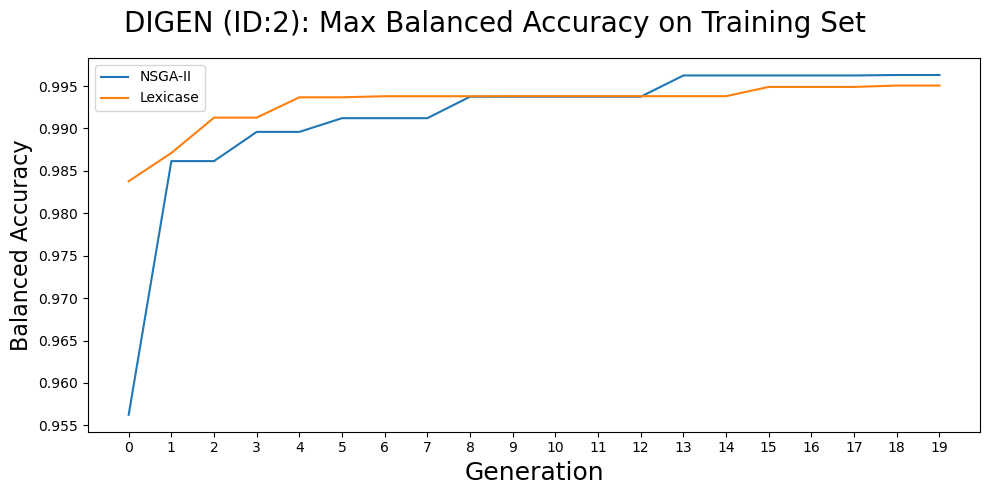

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


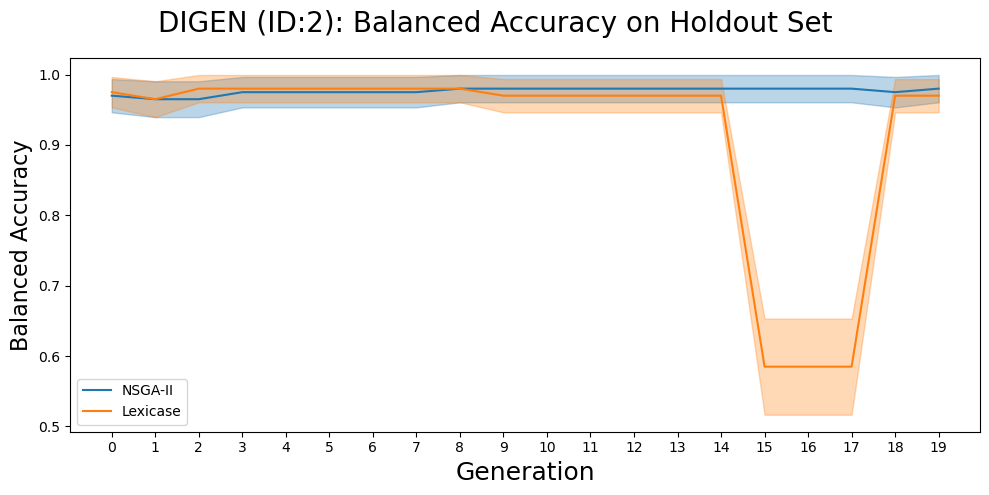

4


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5887500000000001

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=54, p=1, weights=distance)


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["lower_ci_holdout"][k] = p-1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

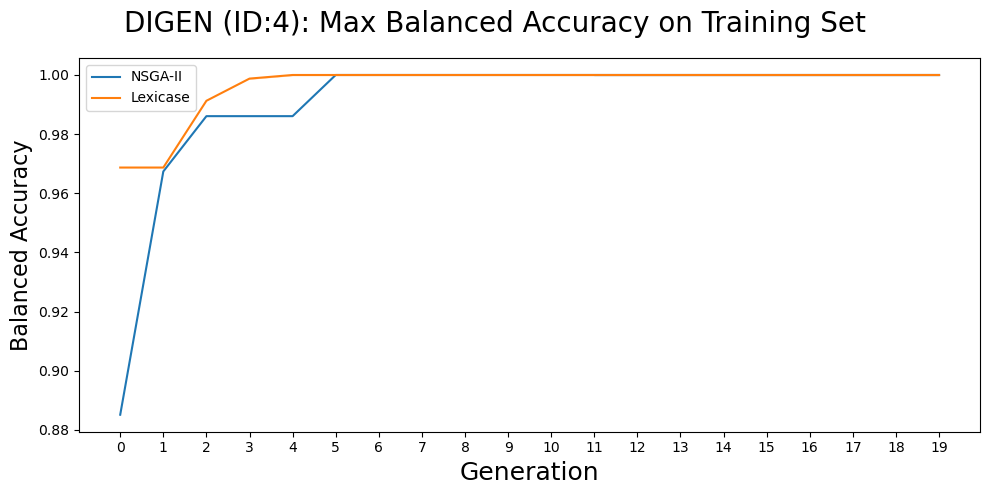

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


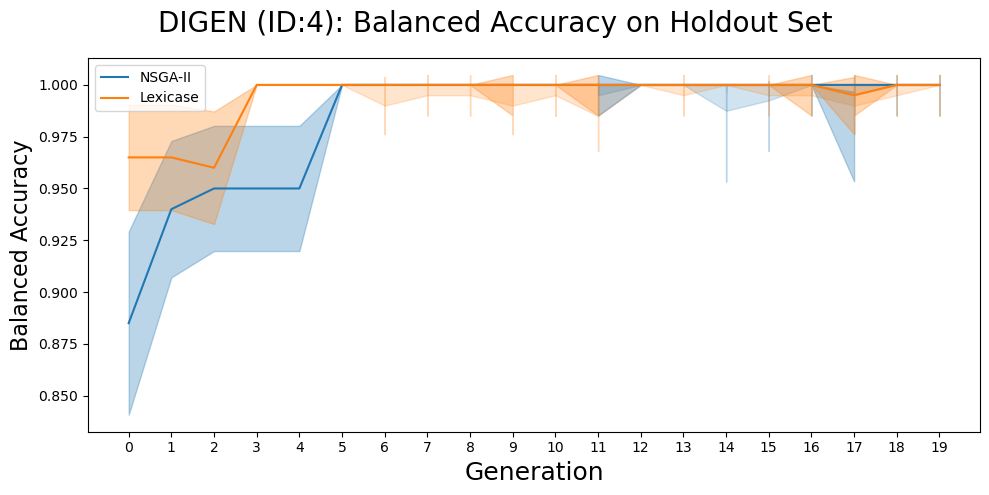

7


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9024030644152596

Best pipeline: GradientBoostingClassifier(StandardScaler(input_matrix), learning_rate=0.5, max_depth=8, max_features=0.9500000000000001, min_samples_leaf=13, min_samples_split=3, n_estimators=100, subsample=0.9500000000000001)


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["lower_ci_holdout"][k] = p-1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

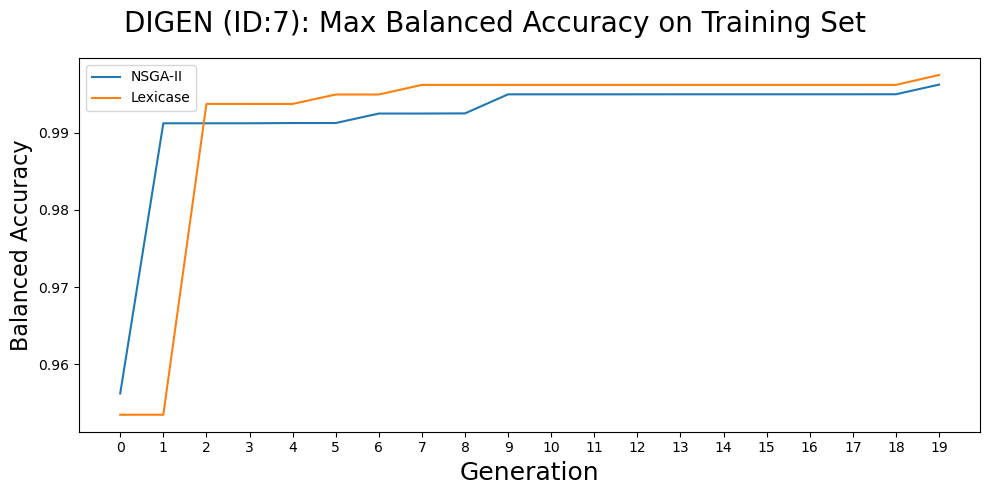

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


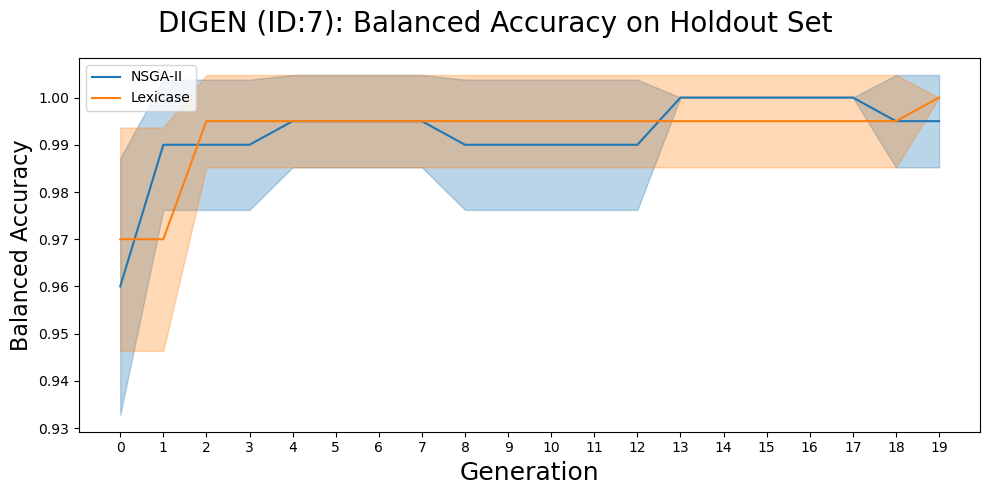

14


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7250218886804253

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.5, max_depth=4, min_child_weight=8, n_estimators=100, n_jobs=1, subsample=0.6500000000000001, verbosity=0)


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["lower_ci_holdout"][k] = p-1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

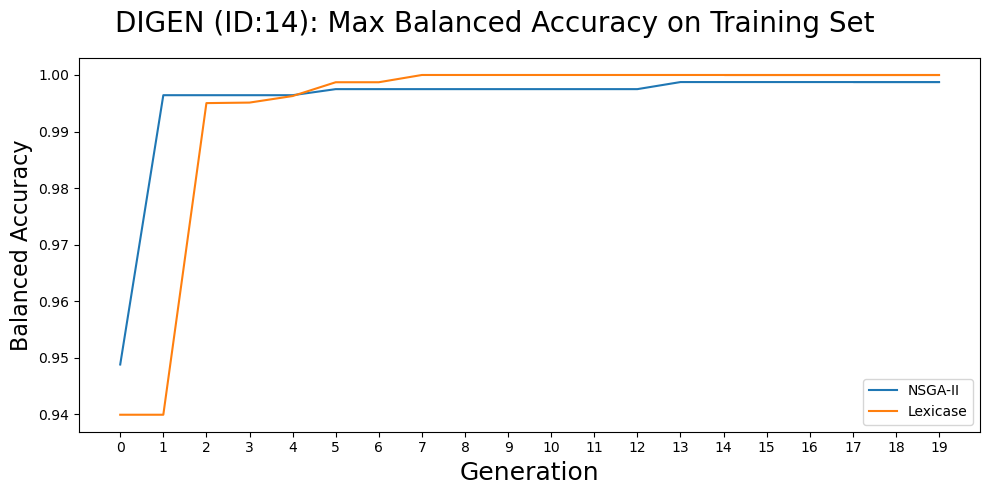

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


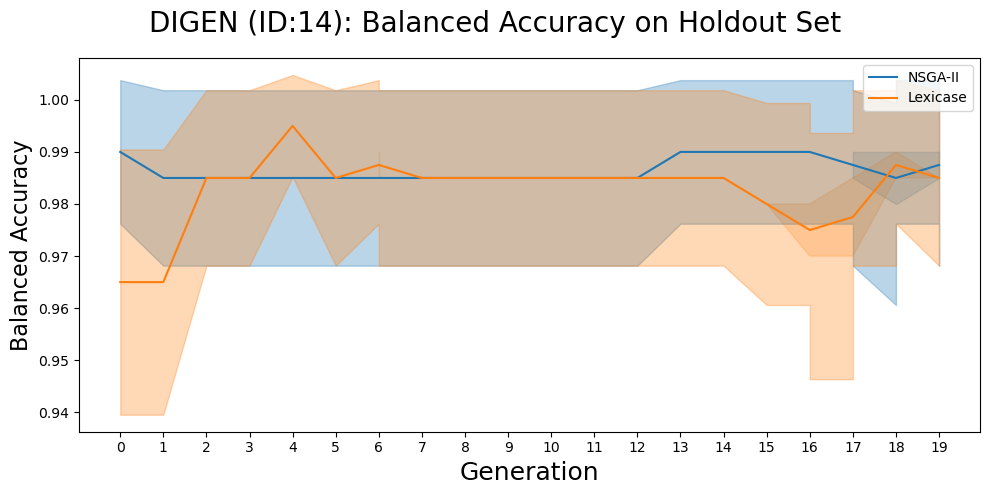

23


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5117154988785284

Best pipeline: SGDClassifier(OneHotEncoder(input_matrix, minimum_fraction=0.05, sparse=False, threshold=10), alpha=0.01, eta0=1.0, fit_intercept=True, l1_ratio=0.25, learning_rate=invscaling, loss=squared_hinge, penalty=elasticnet, power_t=100.0)


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["lower_ci_holdout"][k] = p-1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

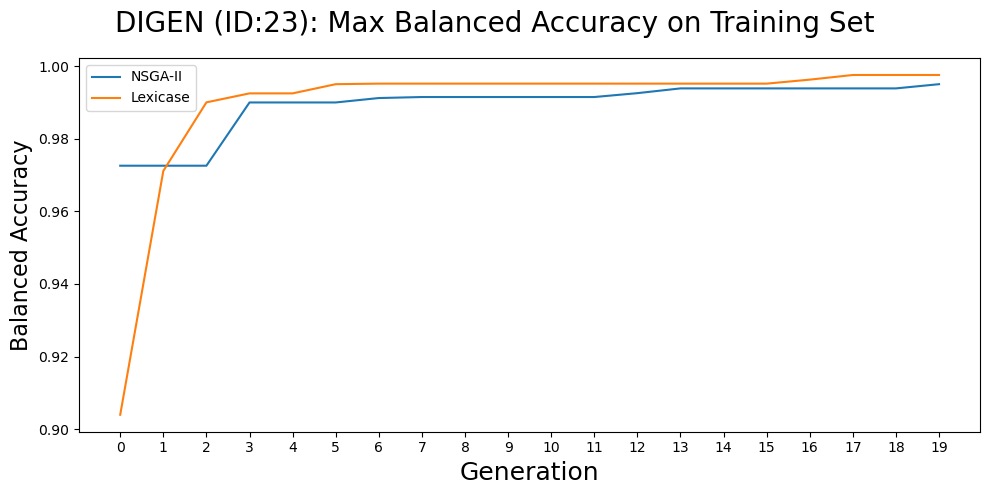

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


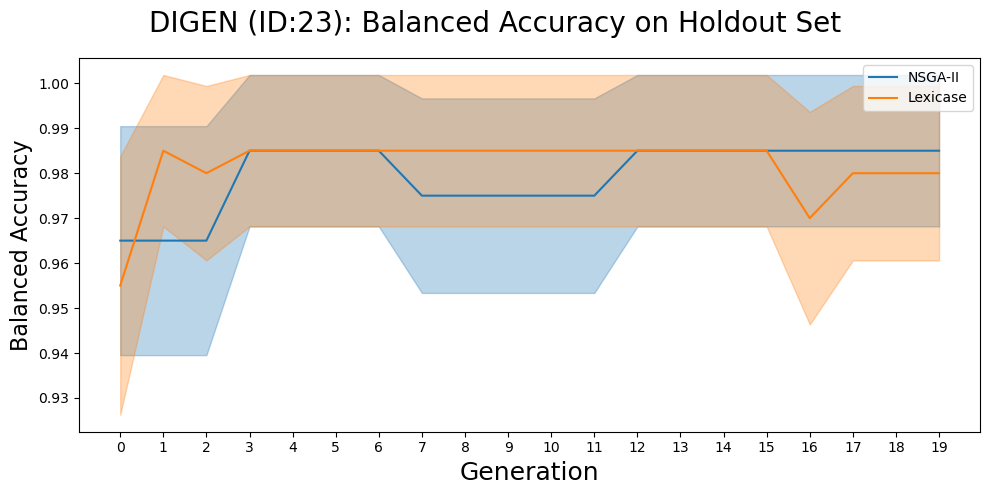

24


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5770767208828826

Best pipeline: DecisionTreeClassifier(LinearSVC(input_matrix, C=10.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.1), criterion=gini, max_depth=6, min_samples_leaf=14, min_samples_split=16)


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["lower_ci_holdout"][k] = p-1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

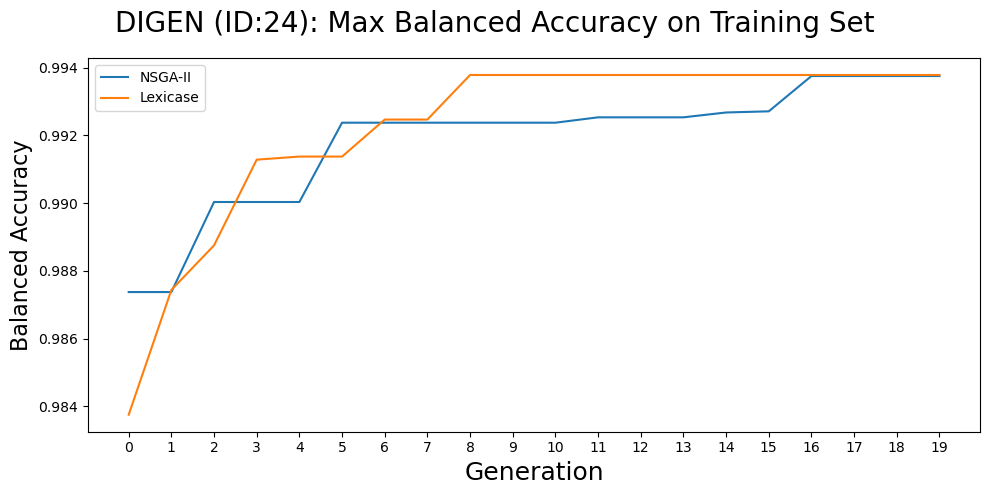

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


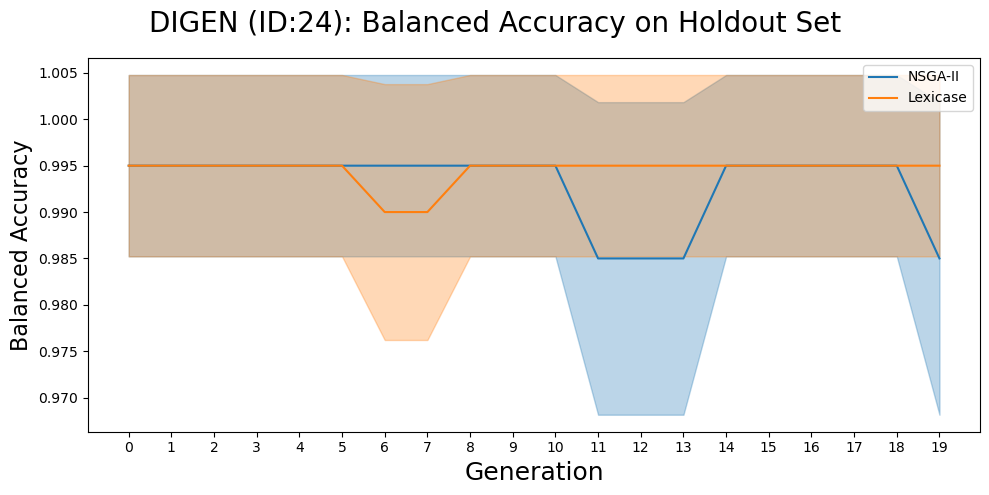

25


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6146091307066917

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.01, max_depth=5, max_features=0.4, min_samples_leaf=5, min_samples_split=18, n_estimators=100, subsample=0.6000000000000001)


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["lower_ci_holdout"][k] = p-1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

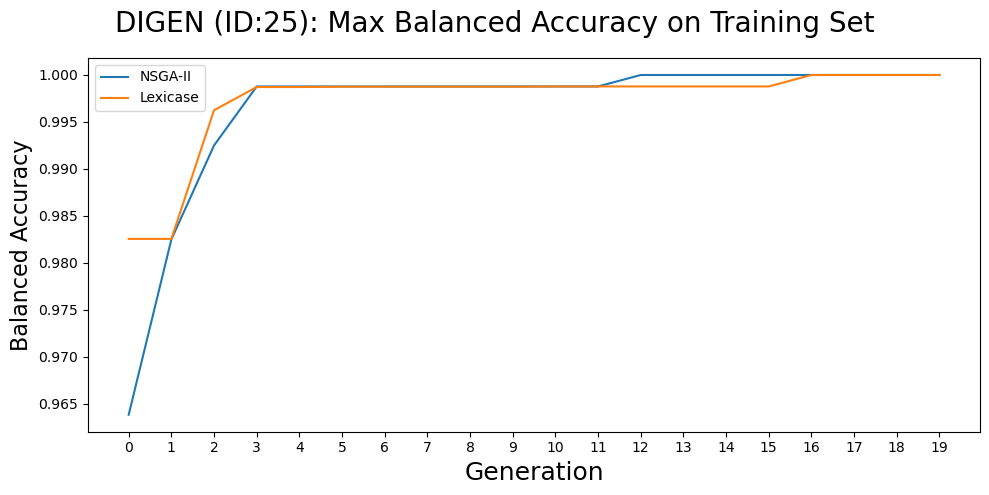

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


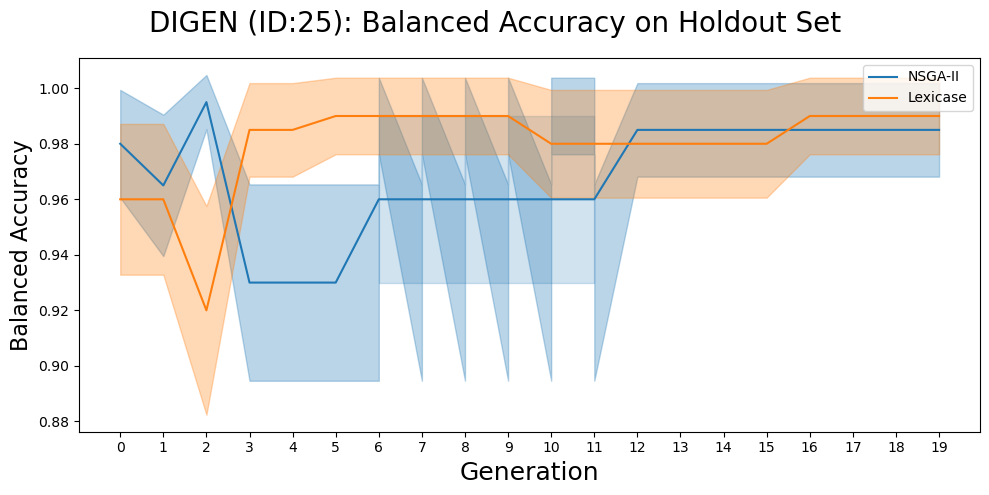

27


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5620934959349595

Best pipeline: GradientBoostingClassifier(LinearSVC(input_matrix, C=0.01, dual=True, loss=squared_hinge, penalty=l2, tol=0.001), learning_rate=0.01, max_depth=6, max_features=0.2, min_samples_leaf=8, min_samples_split=2, n_estimators=100, subsample=0.9500000000000001)


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["lower_ci_holdout"][k] = p-1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

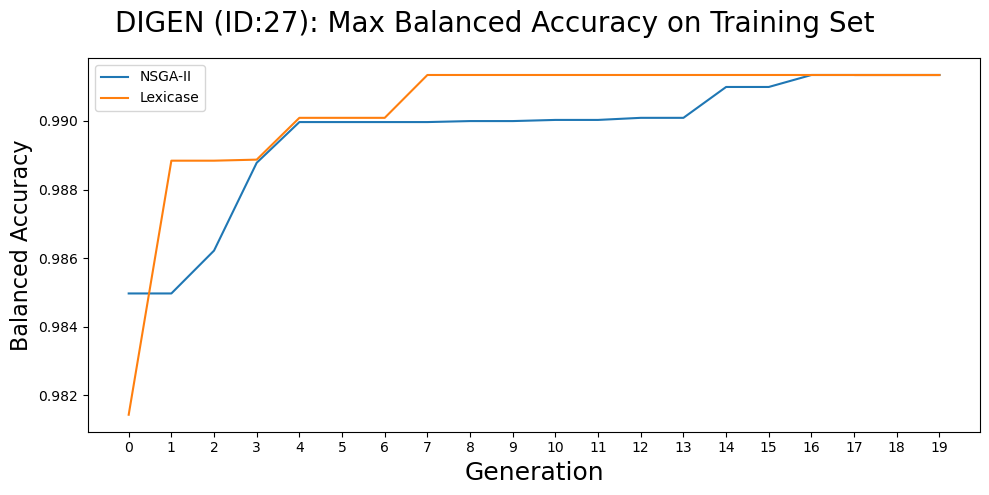

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


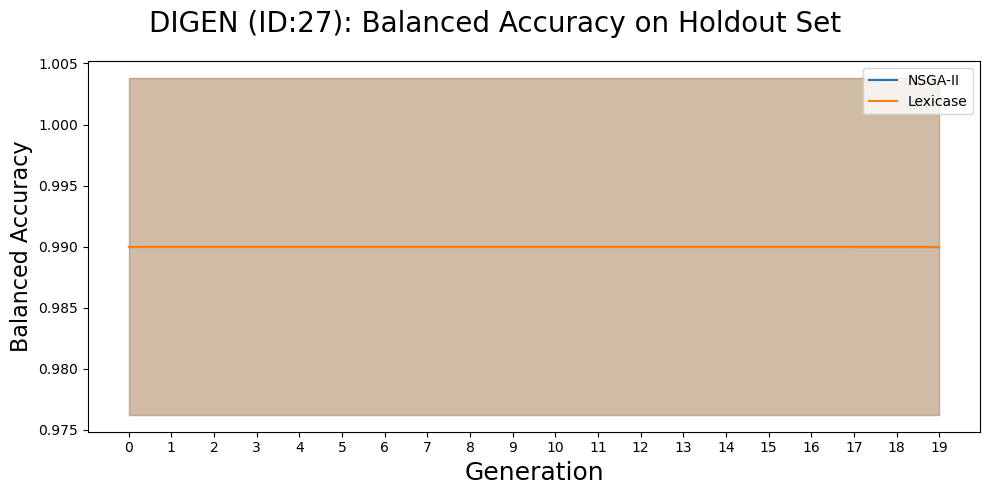

28


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5125

Best pipeline: BernoulliNB(input_matrix, alpha=100.0, fit_prior=True)


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["lower_ci_holdout"][k] = p-1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

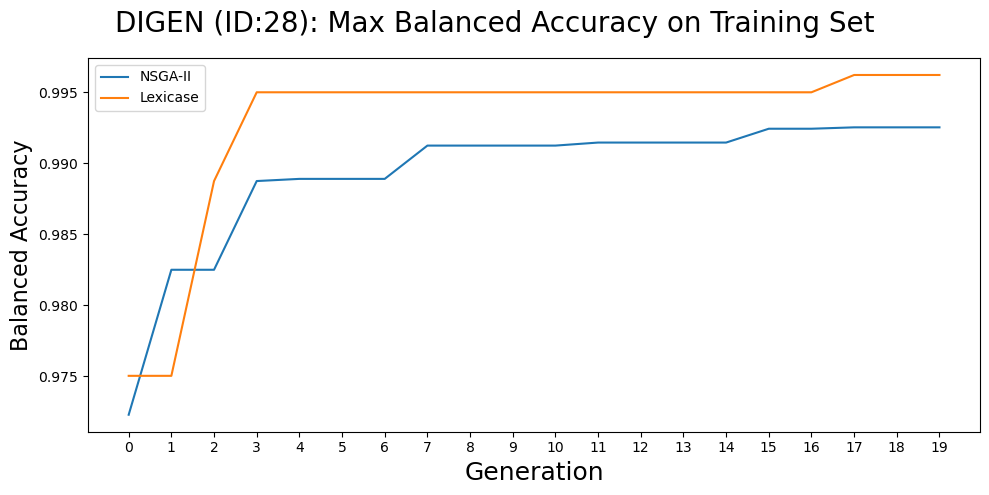

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


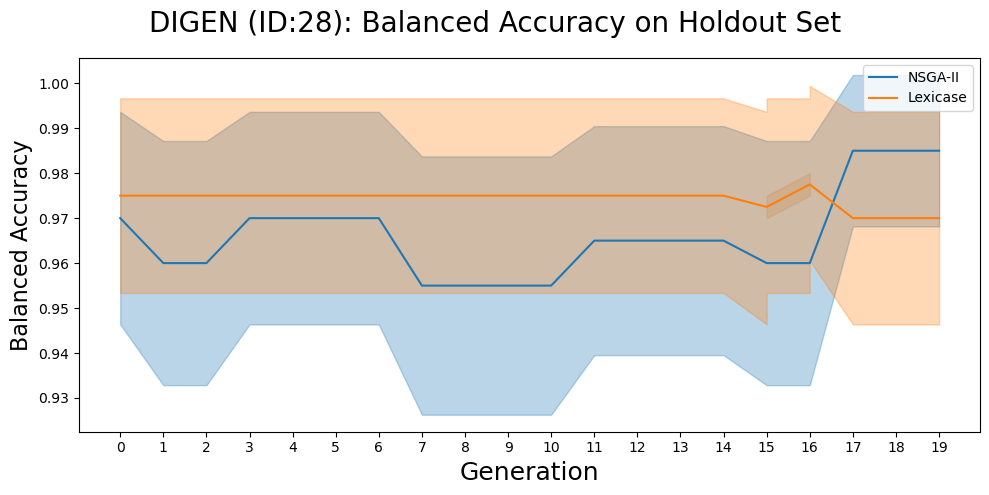

30


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5562054409005628

Best pipeline: KNeighborsClassifier(input_matrix, n_neighbors=51, p=2, weights=distance)


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["lower_ci_holdout"][k] = p-1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

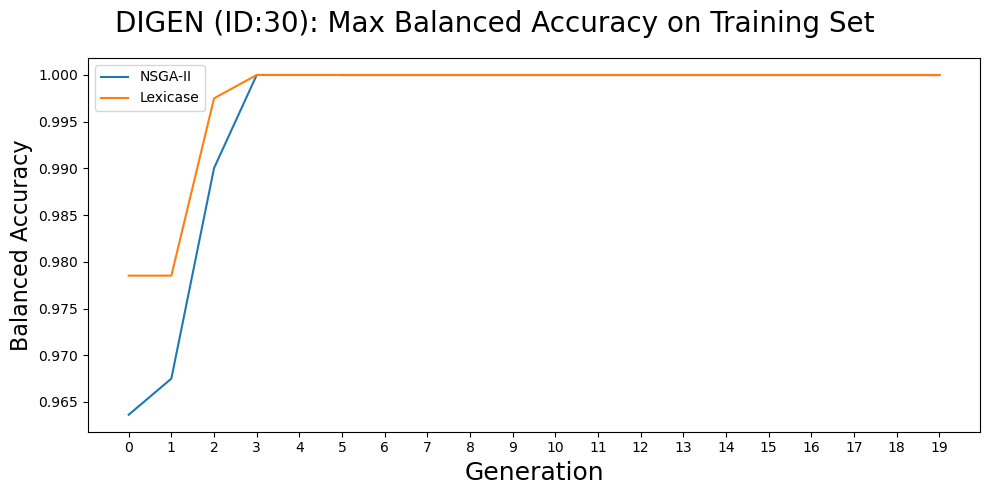

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


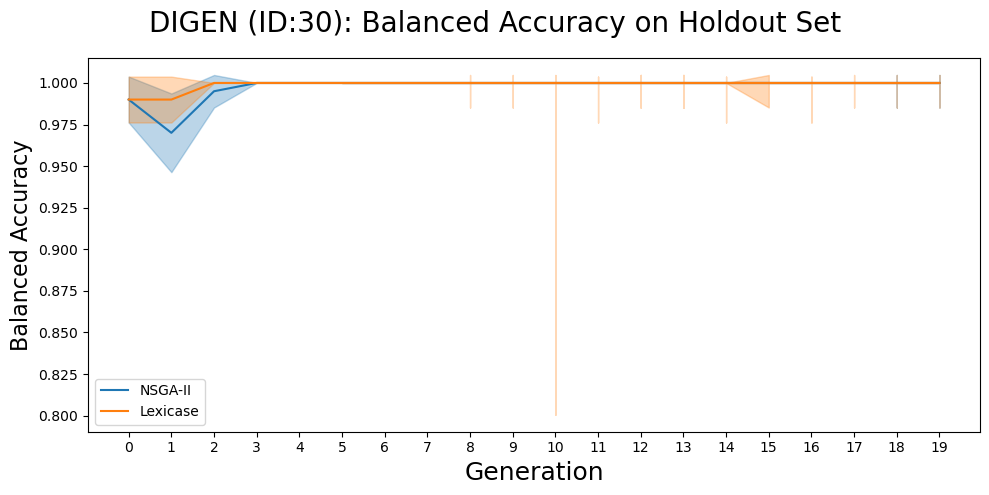

32


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5304080675422138

Best pipeline: AdaBoostClassifier(VarianceThreshold(input_matrix, threshold=0.0001), learning_rate=1.0, n_estimators=100)


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["lower_ci_holdout"][k] = p-1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

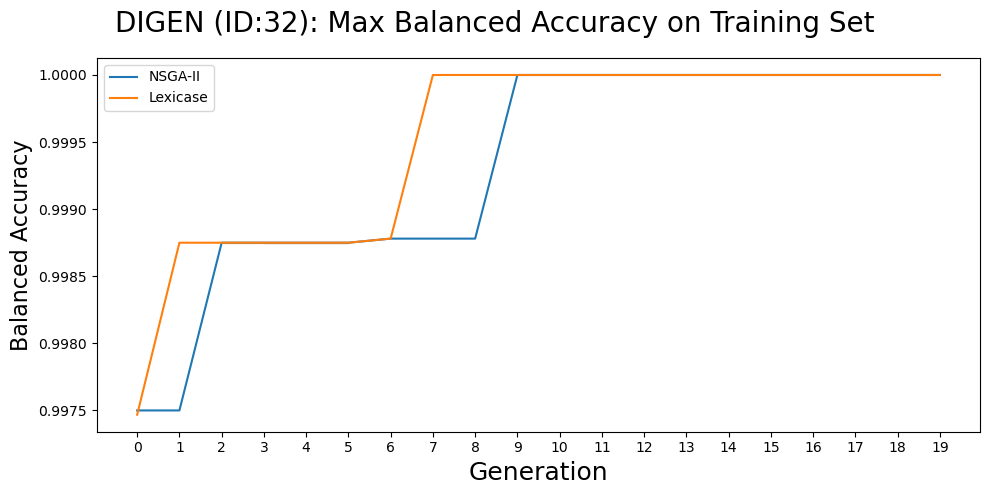

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


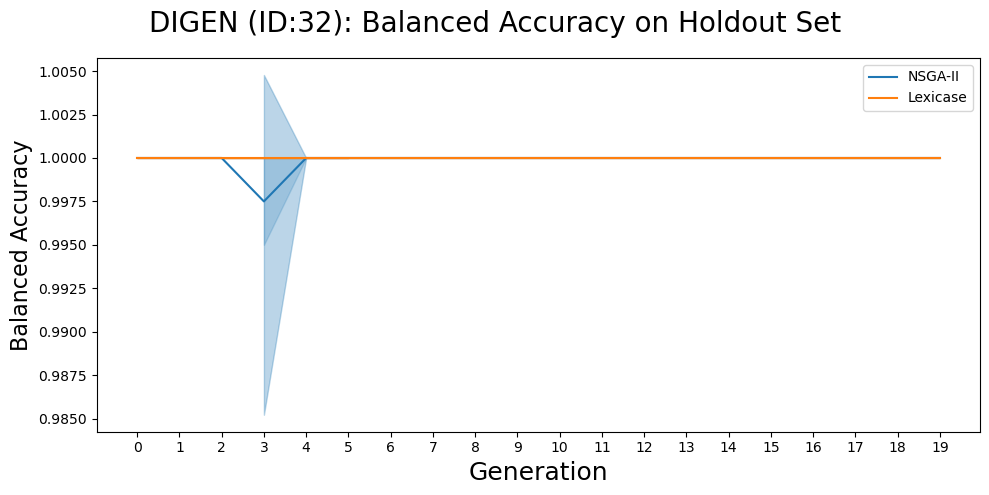

35


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6832082551594747

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.5, max_depth=7, min_child_weight=7, n_estimators=100, n_jobs=1, subsample=0.5, verbosity=0)


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["lower_ci_holdout"][k] = p-1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

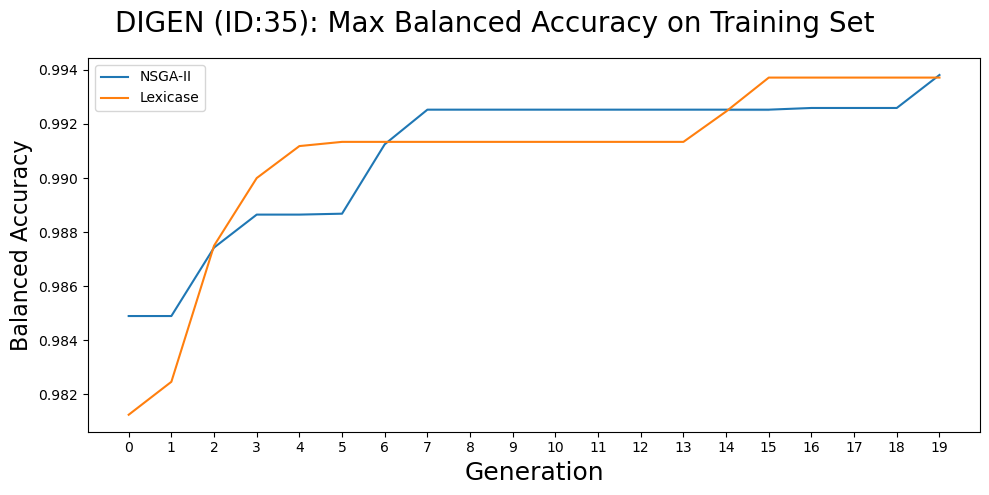

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


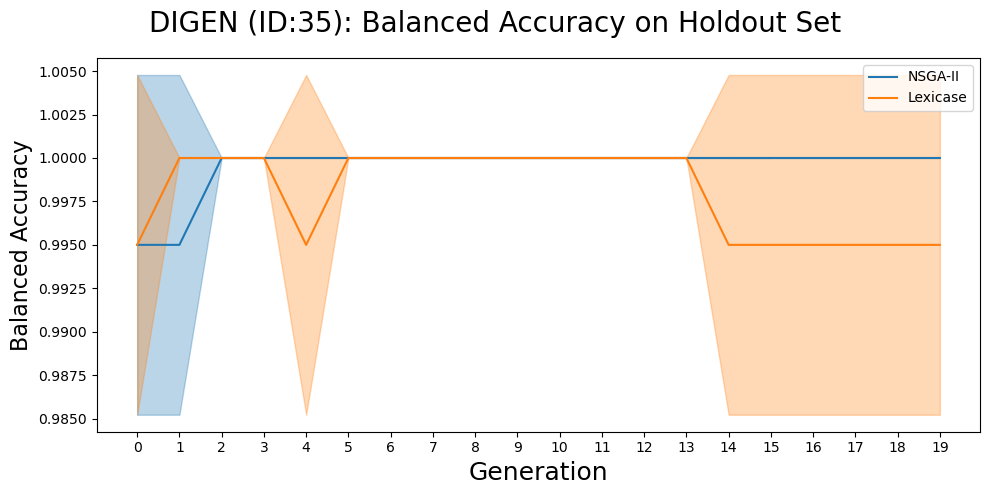

40


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6099867104440275

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.7000000000000001, min_samples_leaf=9, min_samples_split=15, n_estimators=100)


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["lower_ci_holdout"][k] = p-1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/1871421504.py:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

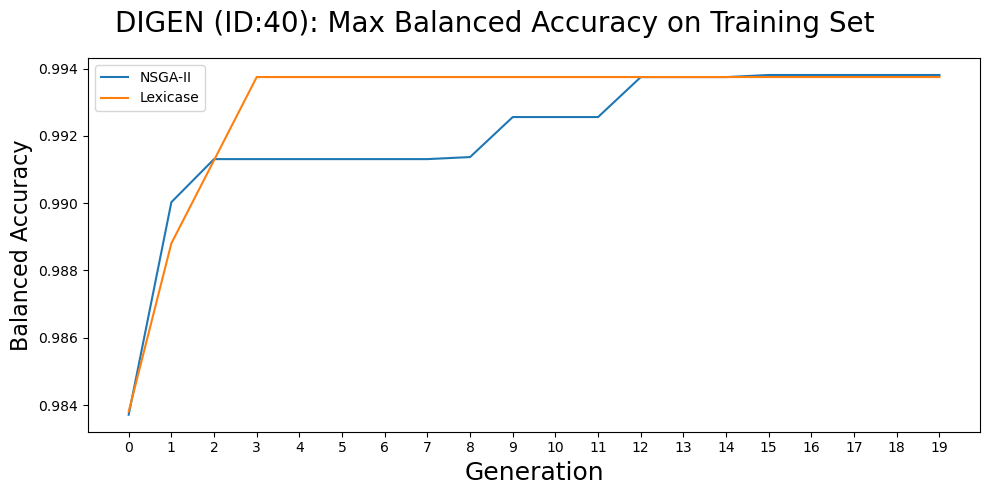

/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


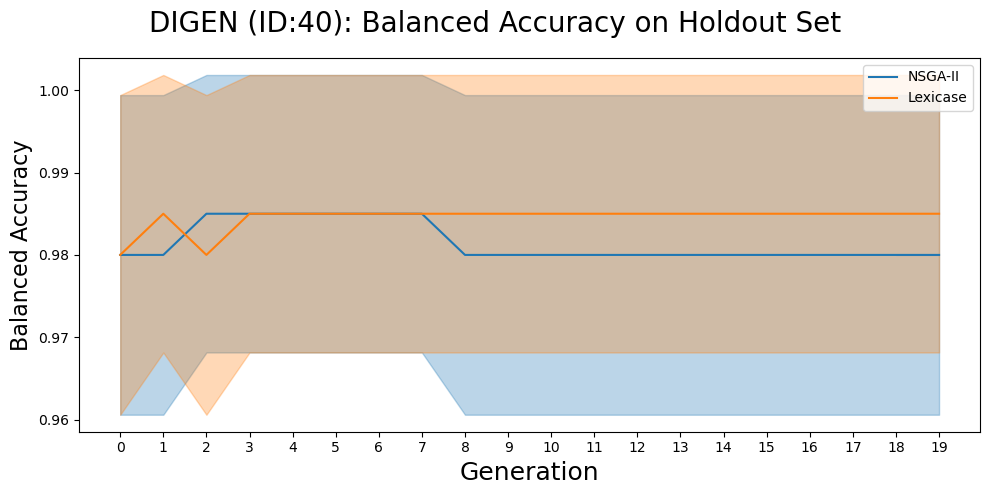

In [187]:
#DIGEN plotting

from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import statistics
import dill as pickle
import sys
from tpot import TPOTClassifier
from deap import creator
sys.path.append('/Users/matsumoton/Git/digen')
from digen import Benchmark

benchmark=Benchmark()
plt.rcParams["figure.figsize"] = (30,16)

#directoryevs = ["baseline_final","lexicase_final","epsbestlex_final"]
directoryevs = ["baseline_final","epsbestlex_final"]
name_values = {
    "baseline_final" : "NSGA-II",
    "/baseline_dynamic/baseline_dynamic" : "baseline_dynamic",
    "lexicase_final" : "Lexicase",
    "/lexicase_dynamic/lexicase_dynamic" : "lexicase_dynamic",
    "/baseline_gen100/baseline_gen100" : "NSGA-II",
    "/lexicase_gen100/lexicase_gen100" : "Lexicase",
    "/selbest/selbest" : "selbest",
    "/autoepslexicase/autoepslexicase" : "Lexicase",
    "epsbestlex_final" : "Lexicase"
}

name_values_summary = {
    "baseline_final" : "baseline",
    "epsbestlex_final" : "epsbestlex",
}

total_runs = 40
result = {}
for j in [2,4,7,14,23,24,25,27,28,30,32,35,40]:
#for j in [2,4,24,28]:
    print(j)

    dataset=benchmark.load_dataset('digen'+str(j))

    X, Y = extract_labels(dataset, "target")
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8,random_state=5)
    
    tpot = TPOTClassifier(verbosity=2, population_size=1, generations=1, track_fitnesses=True,
        track_generations=True, 
        resource_logging=True,test_x = X_test, test_y = y_test, scoring="balanced_accuracy", cv=10, dynamic_rates = True)
    tpot.fit(X_train, y_train)

    ev = []
    for directoryev in directoryevs:
        temp_ev = [] 
        for i in range(total_runs):
            ev_df_name = f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/digen/results_pop40_gen20_{directoryev}/pareto_fitnesses/digen{j}_run_{i}_evolution_pop40_gen20.csv"
            #ev_df_name = f"/Users/matsumoton/pareto/anges{directoryev}_{i}_pareto_fitness.csv"
            #ev_df_name = f"/Users/matsumoton/Git/results_pop40_gen20_{directoryev}/pareto_fitnesses/digen{j}_run_{i}_evolution_pop40_gen20.csv"
            if not exists(ev_df_name):
                continue
            fitness_df = pd.read_csv(ev_df_name, sep=',')
            fitness_df = fitness_df[~fitness_df.isin([np.nan, np.inf, -np.inf]).any(1)]
            temp_ev.append(fitness_df)

        temp_ev = pd.concat(temp_ev)
        temp_ev["type"] = name_values[directoryev]
        
        ev.append(temp_ev)

    frame_df = pd.concat(ev)
    frame_df = frame_df[~frame_df.isin([np.nan, np.inf, -np.inf]).any(1)]

    bestpipelines = []
    for directoryev in directoryevs:
        tempdf = frame_df[frame_df["type"] == name_values[directoryev]]
        tempdf = tempdf.reset_index()
        #print(name_values[directoryev])
        #print(tempdf.iloc[tempdf['cv_score'].idxmax()])
        
        tempdf = tempdf[tempdf.groupby(['generation'],sort=False)['cv_score'].transform(max) == tempdf['cv_score']]
        tempdf = tempdf.sort_values(by="generation")
        #print(tempdf)
        bestpipelines.append(tempdf)
    bestpipelines = pd.concat(bestpipelines)
    bestpipelines = bestpipelines.reset_index()


    bestpipelines["upper_ci_holdout"] = 0
    bestpipelines["lower_ci_holdout"] = 0
    bestpipelines["operator_count"] = 0


    prev_pipeline = ''
    p = s = op = 0
    for k in range(bestpipelines.shape[0]):
        #print(k)
        pipeline = bestpipelines["pipeline"][k]
        if prev_pipeline == pipeline:
            bestpipelines["upper_ci_holdout"][k] = p+1.96*s
            bestpipelines["lower_ci_holdout"][k] = p-1.96*s
            bestpipelines["operator_count"][k] = op
            bestpipelines["holdout_score"][k] = p
            continue
        prev_pipeline = pipeline
        #print(pipeline)

        test = creator.Individual.from_string(pipeline, tpot._pset)
        #print(test)
        
        pipeline_fitted = tpot._toolbox.compile(expr=test)
        pipeline_fitted.fit(X_train, y_train)

        operator_count = 0
        for node in test:
            if type(node) is deap.gp.Primitive and node.name != "CombineDFs":
                operator_count += 1

        predictions = pipeline_fitted.predict(X_test)
        p = sum(pipeline_fitted.predict(X_test) == y_test)/len(y_test)
        s = np.sqrt(p*(1-p)/len(y_test))
        op = operator_count
        #predictions = pipeline_fitted.predict(X_train)
        #p = sum(pipeline_fitted.predict(X_train) == y_train)/len(y_train)
        #s = np.sqrt(p*(1-p)/len(y_train))
        bestpipelines["upper_ci_holdout"][k] = p+1.96*s
        bestpipelines["lower_ci_holdout"][k] = p-1.96*s
        bestpipelines["operator_count"][k] = operator_count
        bestpipelines["holdout_score"][k] = p

    #print(bestpipelines)
    
    bestpipelines["generation"] = bestpipelines["generation"].astype(str)

    plt.rcParams["figure.figsize"] = (10,5)

    fig = plt.figure()
    seaborn.lineplot(x="generation",y="cv_score",hue="type",data=bestpipelines, 
    estimator=np.max,label = "type" if i == 0 else "")#.set(title="Digen "+str(j)+" Max Balanced Accuracy on Training Set")
    fig.suptitle("DIGEN (ID:"+str(j)+ '): Max Balanced Accuracy on Training Set', fontsize=20)
    plt.ylabel("Balanced Accuracy",fontsize=16)
    plt.xlabel('Generation', fontsize=18)
    plt.gca().legend().set_title('')
    plt.savefig(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/final_plots_autoeps/digen{j}_pareto_max_training_set_full.png")
    plt.show()

    
    fig = plt.figure()
    seaborn.lineplot(x="generation",y="holdout_score",hue="type",data=bestpipelines, 
    estimator=np.median,label = "type" if i == 0 else "")#.set(title="Digen "+str(j)+" Balanced Accuracy on Holdout Score")
    color_counter = 0
    for directoryev in directoryevs:
        tempdf = bestpipelines[bestpipelines["type"] == name_values[directoryev]]
        plt.fill_between(tempdf["generation"],tempdf["upper_ci_holdout"],tempdf["lower_ci_holdout"],color='C' + str(color_counter),alpha=0.3)
        color_counter = color_counter + 1
    fig.suptitle("DIGEN (ID:"+str(j)+ '): Balanced Accuracy on Holdout Set', fontsize=20)
    plt.ylabel("Balanced Accuracy",fontsize=16)
    plt.xlabel('Generation', fontsize=18)
    plt.gca().legend().set_title('')
    plt.savefig(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/final_plots_autoeps/digen{j}_pareto_max_holdoutscore_full.png")
    plt.show()

    #seaborn.lineplot(x="generation",y="operator_count",hue="type",data=bestpipelines, label = "type" if i == 0 else "").set(title="Digen "+str(j)+" Max Balanced Accuracy on Training Set")
    #plt.show()


In [140]:
#DIGEN plotting

from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import statistics
import dill as pickle
import sys
from tpot import TPOTClassifier
from deap import creator
sys.path.append('/Users/matsumoton/Git/digen')
from digen import Benchmark

benchmark=Benchmark()
plt.rcParams["figure.figsize"] = (30,16)

#directoryevs = ["baseline_final","lexicase_final","epsbestlex_final"]
directoryevs = ["baseline_final","epsbestlex_final"]
name_values = {
    "baseline_final" : "NSGA-II",
    "/baseline_dynamic/baseline_dynamic" : "baseline_dynamic",
    "lexicase_final" : "Lexicase",
    "/lexicase_dynamic/lexicase_dynamic" : "lexicase_dynamic",
    "/baseline_gen100/baseline_gen100" : "NSGA-II",
    "/lexicase_gen100/lexicase_gen100" : "Lexicase",
    "/selbest/selbest" : "selbest",
    "/autoepslexicase/autoepslexicase" : "Lexicase",
    "epsbestlex_final" : "Lexicase"
}

name_values_summary = {
    "baseline_final" : "baseline",
    "epsbestlex_final" : "epsbestlex",
}

total_runs = 40
result = {}
for j in [2,4,7,14,23,24,25,27,28,30,32,35,40]:
    print(j)

    dataset=benchmark.load_dataset('digen'+str(j))

    X, Y = extract_labels(dataset, "target")
    X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8,random_state=5)

    tpot = TPOTClassifier(verbosity=2, population_size=1, generations=1, track_fitnesses=True,
        track_generations=True, 
        resource_logging=True,test_x = X_test, test_y = y_test, scoring="balanced_accuracy", cv=10, dynamic_rates = True)
    tpot.fit(X_train, y_train)
    
    ev = []
    for directoryev in directoryevs:
        ev_df_name = f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/summary_data/digen_{j}_{name_values_summary[directoryev]}.csv"
    
        convergence_models = pd.read_csv(ev_df_name, sep=',')
        temp_ev = [] 
        for i in range(total_runs):
            ev_df_name = f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/digen/results_pop40_gen20_{directoryev}/pareto_fitnesses/digen{j}_run_{i}_evolution_pop40_gen20.csv"
            #ev_df_name = f"/Users/matsumoton/pareto/anges{directoryev}_{i}_pareto_fitness.csv"
            #ev_df_name = f"/Users/matsumoton/Git/results_pop40_gen20_{directoryev}/pareto_fitnesses/digen{j}_run_{i}_evolution_pop40_gen20.csv"
            if not exists(ev_df_name):
                continue
            fitness_df = pd.read_csv(ev_df_name, sep=',')
            fitness_df = fitness_df[~fitness_df.isin([np.nan, np.inf, -np.inf]).any(1)]
            convergence_models_temp = fitness_df[fitness_df["generation"] == convergence_models["gen"][i]]
            convergence_models_temp = convergence_models_temp.reset_index()
            temp_ev.append(convergence_models_temp.iloc[[convergence_models_temp['cv_score'].idxmax()]])

        temp_ev = pd.concat(temp_ev)
        temp_ev["type"] = name_values_summary[directoryev]
        
        ev.append(temp_ev)

    frame_df = pd.concat(ev)
    frame_df = frame_df[~frame_df.isin([np.nan, np.inf, -np.inf]).any(1)]

    bestpipelines = frame_df[~frame_df.isin([np.nan, np.inf, -np.inf]).any(1)]
    bestpipelines = bestpipelines.reset_index()
    from deap import creator
    import deap

    bestpipelines["upper_ci_holdout"] = 0
    bestpipelines["lower_ci_holdout"] = 0
    bestpipelines["operator_count"] = 0


    prev_pipeline = ''
    p = s = op = 0
    for k in range(bestpipelines.shape[0]):
        print(k)
        pipeline = bestpipelines["pipeline"][k]
        if prev_pipeline == pipeline:
            bestpipelines["upper_ci_holdout"][k] = p+1.96*s
            bestpipelines["lower_ci_holdout"][k] = p-1.96*s
            bestpipelines["operator_count"][k] = op
            bestpipelines["holdout_score"][k] = p
            continue
        prev_pipeline = pipeline
        #print(pipeline)

        test = creator.Individual.from_string(pipeline, tpot._pset)
        #print(test)
        
        pipeline_fitted = tpot._toolbox.compile(expr=test)
        pipeline_fitted.fit(X_train, y_train)

        operator_count = 0
        for node in test:
            if type(node) is deap.gp.Primitive and node.name != "CombineDFs":
                operator_count += 1

        predictions = pipeline_fitted.predict(X_test)
        p = sum(pipeline_fitted.predict(X_test) == y_test)/len(y_test)
        s = np.sqrt(p*(1-p)/len(y_test))
        op = operator_count
        #predictions = pipeline_fitted.predict(X_train)
        #p = sum(pipeline_fitted.predict(X_train) == y_train)/len(y_train)
        #s = np.sqrt(p*(1-p)/len(y_train))
        bestpipelines["holdout_score"][k] = p
        bestpipelines["upper_ci_holdout"][k] = p+1.96*s
        bestpipelines["lower_ci_holdout"][k] = p-1.96*s
        bestpipelines["operator_count"][k] = operator_count

    bestpipelines.to_csv(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/summary_data/digen{j}_ci.csv", sep=',', index=False)



2


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.493099593495935

Best pipeline: SGDClassifier(input_matrix, alpha=0.01, eta0=0.1, fit_intercept=True, l1_ratio=0.25, learning_rate=invscaling, loss=log, penalty=elasticnet, power_t=0.5)
0


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

1


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


2


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


3


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


4


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

5
6


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


7


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


8


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


9


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


10


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


11


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


12


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


13


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


14


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


15


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


16


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


17


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


18


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


19


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


20


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


21


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


22


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


23


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


24


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


25


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


26


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


27


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


28


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


29


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


30


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


31


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

32
33


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


34


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


35


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


36


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


37


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


38


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


39


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


40


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders

41
42


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


43


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


44


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


45


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsu

46


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


47


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


48


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


49


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

50
51


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


52


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


53


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


54


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


55


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


56


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


57


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


58


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


59


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

60
61


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


62


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

63
64


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


65


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


66


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


67


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


68


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


69


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


70


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


71


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


72


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

73
74


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


75


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


76


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


77


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


78


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


79
4


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6287499999999999

Best pipeline: KNeighborsClassifier(MaxAbsScaler(input_matrix), n_neighbors=9, p=1, weights=uniform)
0


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

1


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

2
3


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


4


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


5


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


6


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


7


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


8


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


9


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


10


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


11


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


12


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

13
14


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


15


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


16


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


17


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

18
19


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


20


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


21


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


22


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


23


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


24


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


25


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


26


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


27


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


28


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


29


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


30


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


31


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


32


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


33


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


34


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


35


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


36


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


37


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


38


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


39


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


40


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


41


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


42


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


43


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


44


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


45


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


46


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


47


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


48


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


49


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


50


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders

51
52


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


53


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


54


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


55


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


56


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


57


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


58


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


59


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


60


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


61


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


62


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


63


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


64


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

65
66


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


67


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


68


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


69


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


70


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


71


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


72


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


73


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


74


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


75


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


76


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


77


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


78


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

79
7


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5127493746091307

Best pipeline: GaussianNB(RFE(input_matrix, criterion=gini, max_features=0.7000000000000001, n_estimators=100, step=0.55))
0


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

1


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


2


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


3


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


4


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


5


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

6
7


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

8
9


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


10


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


11


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


12


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


13


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


14


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


15


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


16


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


17


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

18
19


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


20


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


21


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


22


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


23


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


24


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


25


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


26


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


27


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


28


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


29


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


30


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


31


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


32


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


33


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


34


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


35


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


36


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


37


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


38


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


39


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


40


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


41


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

42
43


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


44


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


45


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

46
47


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


48


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


49


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


50


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


51


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


52


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


53


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


54


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


55


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


56


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


57


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


58


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


59


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


60


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


61


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


62


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


63


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


64


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


65


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


66


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


67
68


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


69
70


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


71


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


72


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


73


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


74


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


75


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


76


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


77


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


78


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


79
14


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5062499999999999

Best pipeline: SGDClassifier(GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=2, max_features=0.8, min_samples_leaf=9, min_samples_split=12, n_estimators=100, subsample=0.8500000000000001), alpha=0.01, eta0=0.1, fit_intercept=False, l1_ratio=0.5, learning_rate=constant, loss=perceptron, penalty=elasticnet, power_t=100.0)
0


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/

1


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


2


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

3
4


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


5


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

6
7


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


8


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


9


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

10
11


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


12


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


13


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


14


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


15


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


16
17


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

18
19
20


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


21


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


22


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


23


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


24


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


25


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


26


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


27


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


28


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


29


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


30


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


31


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


32


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


33


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


34


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


35


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


36


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


37


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


38


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


39


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


40


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


41


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


42


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


43


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


44


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


45


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


46


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

47
48


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


49


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


50


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


51


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


52


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


53


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


54


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


55


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

56
57


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


58


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


59


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


60


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


61


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


62


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


63


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


64


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


65


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


66


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


67


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


68


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


69


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


70


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


71


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


72


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


73


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


74


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


75


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


76


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


77


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


78


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


79
23


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5024593495934959

Best pipeline: AdaBoostClassifier(input_matrix, learning_rate=1.0, n_estimators=100)
0


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

1
2


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


3


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


4


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


5


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


6


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


7


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


8


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


9


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


10


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


11


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


12


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


13


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


14


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

15
16


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


17


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


18


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


19


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


20


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


21


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


22


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


23


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


24


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

25
26


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


27


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


28


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


29


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


30


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


31


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


32


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


33


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


34


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


35


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

36
37


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


38


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


39


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


40


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


41


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


42


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

43
44


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


45


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


46


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


47


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


48


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


49


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


50


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


51


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


52


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


53


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


54


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


55


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


56


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


57


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


58


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


59


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


60


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


61


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


62


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

63
64


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


65


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


66


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


67


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


68


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


69


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


70


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


71


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


72


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


73


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

74
75


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


76


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


77


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


78


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


79
24


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5436444652908067

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.05, min_samples_leaf=15, min_samples_split=15, n_estimators=100)
0
1


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

2


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


3


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


4


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


5


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

6
7


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


8


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


9


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


10


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

11
12
13


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


14


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


15


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


16
17


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

18
19


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


20


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


21


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


22


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

23
24


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


25


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


26


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


27


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


28


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


29


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


30


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


31


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


32


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


33


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


34


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


35


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


36


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


37


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


38


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


39


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


40


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


41


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


42


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


43


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

44
45
46


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


47


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


48


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


49
50


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


51


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

52
53
54


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

55
56
57


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


58


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


59


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

60
61
62


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


63


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


64


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


65


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


66


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


67


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


68


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


69


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


70


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


71


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


72


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


73


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


74


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


75


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

76
77
78


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


79
25


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6849999999999999

Best pipeline: MLPClassifier(input_matrix, alpha=0.1, learning_rate_init=1.0)
0


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

1


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


2


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


3


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


4


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


5


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


6


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


7


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


8


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


9


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


10


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


11


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


12


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


13


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

14
15


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


16


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


17


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


18


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


19


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders

20
21


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


22


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


23


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


24


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

25
26


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


27


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


28


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


29


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


30


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

31
32


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


33


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

34
35


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


36


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


37


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

38
39


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


40
41


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


42


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


43


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


44


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


45


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


46


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


47


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


48


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


49


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


50


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


51


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


52


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


53


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


54


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


55


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


56


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


57


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


58


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


59


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


60


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


61


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


62


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


63


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


64


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


65


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


66


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


67


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

68
69


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


70


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


71


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


72


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


73


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


74


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

75
76


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

77
78


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


79
27


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5275

Best pipeline: SGDClassifier(ZeroCount(input_matrix), alpha=0.01, eta0=1.0, fit_intercept=True, l1_ratio=0.5, learning_rate=invscaling, loss=hinge, penalty=elasticnet, power_t=0.5)
0


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

1


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


2


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


3


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

4
5
6


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


7


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


8


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


9


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


10


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

11
12
13
14
15


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

16
17


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


18


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


19


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

20
21


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

22
23


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


24


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


25


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


26


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

27
28
29


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


30


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


31


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

32
33


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


34


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


35


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


36


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


37


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


38
39


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


40


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


41


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


42


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

43
44
45


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


46


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


47


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


48


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


49


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


50


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


51


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


52


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


53


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


54


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


55


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


56


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

57
58


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

59
60


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


61


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


62


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


63


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


64


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


65


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


66


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


67


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


68


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


69


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


70


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


71


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


72


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


73


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

74
75
76


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


77


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


78


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


79
28


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5167694094523363

Best pipeline: LinearSVC(Binarizer(input_matrix, threshold=0.2), C=1.0, dual=False, loss=squared_hinge, penalty=l1, tol=0.01)
0


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

1


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


2


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


3


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


4


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


5


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


6


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


7


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


8


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


9


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


10


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


11


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


12


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


13


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


14


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


15


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


16


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


17


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


18


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


19


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


20


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


21


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


22


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


23


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


24


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


25


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


26


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


27


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


28


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


29


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


30


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


31


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


32


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


33


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


34


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


35


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


36


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


37


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


38


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


39


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


40


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


41


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


42


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


43


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


44


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


45


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


46


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


47


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


48


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


49


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


50


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


51


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


52


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


53


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


54


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


55


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


56


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


57


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


58


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


59


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


60


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


61


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


62


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


63


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


64


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


65


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


66


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


67


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


68


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


69


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


70


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


71


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


72


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


73


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


74


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


75
76


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


77


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


78


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


79
30


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.557687617260788

Best pipeline: RandomForestClassifier(OneHotEncoder(input_matrix, minimum_fraction=0.15, sparse=False, threshold=10), bootstrap=False, criterion=gini, max_features=0.3, min_samples_leaf=2, min_samples_split=7, n_estimators=100)
0


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

1


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/

2


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


3


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


4


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

5
6


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


7


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


8


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


9


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


10


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


11


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


12


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


13


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


14


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


15


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


16


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


17


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


18


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


19


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


20


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


21


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


22


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


23


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


24


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


25


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


26


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


27


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


28


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


29


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

30
31


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


32


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


33


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


34


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


35


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


36
37


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


38


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


39


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

40
41


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


42


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


43


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


44


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


45


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


46


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

47
48


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


49


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


50


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


51


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


52


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


53


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


54


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


55


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

56
57


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


58


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


59


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


60


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


61


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


62


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


63


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value 

64


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


65


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


66


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders

67
68


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


69


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


70


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


71


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

72
73


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


74


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


75


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


76


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


77


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


78


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


79


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


32


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.6687687617260788

Best pipeline: ExtraTreesClassifier(MLPClassifier(input_matrix, alpha=0.01, learning_rate_init=1.0), bootstrap=False, criterion=gini, max_features=0.2, min_samples_leaf=16, min_samples_split=2, n_estimators=100)
0


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

1


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

2
3


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


4


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


5


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

6
7
8


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


9


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


10


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


11


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

12
13


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


14


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


15


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

16
17


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


18


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


19


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

20
21


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

22
23


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


24


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


25


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

26
27
28


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

29
30


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


31


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


32
33


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


34


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


35


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


36


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


37


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


38


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


39


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


40


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

41
42


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


43


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


44
45


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


46


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


47


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


48


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


49


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


50


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


51


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


52
53


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


54


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

55
56


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


57


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


58


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


59


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


60


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


61


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

62
63


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


64


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


65


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


66


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


67


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


68


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


69


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


70


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


71


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

72
73


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


74


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


75


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


76


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

77
78


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


79
35


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5039055659787367

Best pipeline: LinearSVC(input_matrix, C=0.0001, dual=True, loss=hinge, penalty=l2, tol=0.01)
0


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

1


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


2


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


3


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


4


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


5


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


6


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


7


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


8


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

9
10


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

11
12


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

13
14


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


15


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


16


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


17


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


18


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


19


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


20


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


21
22


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


23


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


24


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


25


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


26


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


27


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


28


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


29


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


30


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


31


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

32
33


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


34


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


35


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588

36
37


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


38


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


39


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

40
41
42


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

43
44


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


45


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

46
47


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


48


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


49


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


50


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


51


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


52


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


53


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


54
55


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


56


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


57


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


58


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


59


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders

60
61


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


62


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


63


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


64


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


65


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

66
67


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


68


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


69


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

70
71


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


72


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


73


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


74


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


75


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

76
77


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


78


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


79


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


40


Optimization Progress:   0%|          | 0/2 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.5800023452157599

Best pipeline: MLPClassifier(FastICA(input_matrix, tol=0.4), alpha=0.001, learning_rate_init=0.01)
0


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["upper_ci_holdout"][k] = p+1.96*s
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

1


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


2


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


3


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

4
5


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


6


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


7


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


8
9


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


10


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


11


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


12


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


13


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


14


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

15
16
17
18


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


19


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


20


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


21


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


22


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


23


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

24
25


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


26


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


27


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


28


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


29


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


30


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

31
32


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

33
34


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


35


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


36


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


37


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


38


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


39


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


40


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

41
42


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


43


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


44


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


45


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


46


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


47


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


48


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


49


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


50


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


51


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


52
53


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


54


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


55


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


56


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


57


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

58
59


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


60


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


61


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


62


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


63


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


64


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


65


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


66


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


67


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


68


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


69


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


70


/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


71


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


72


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


73


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


74


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


75


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


76


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


77


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


78


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


79


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["holdout_score"][k] = p
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3764588257.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bestpipelines["operator_count"][k] = operator_count


2


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

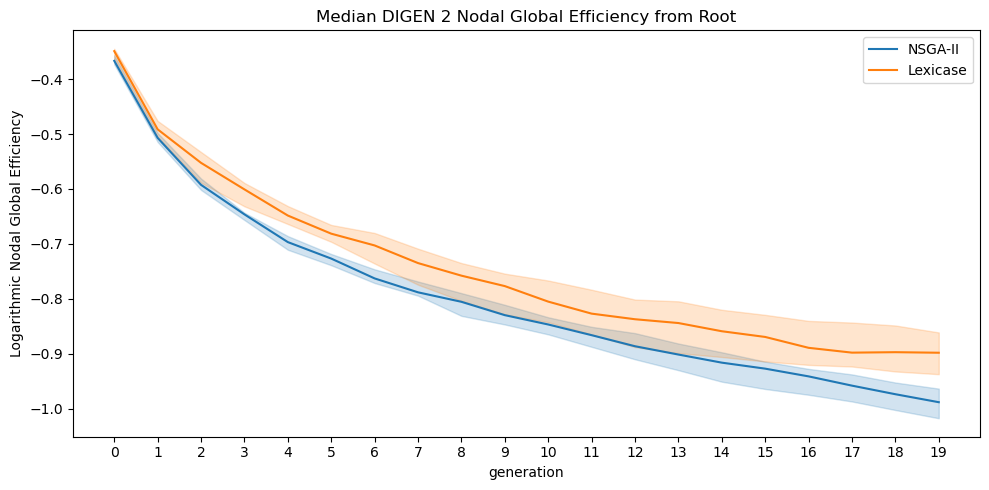

/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["value"] = df["value"].astype(int)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


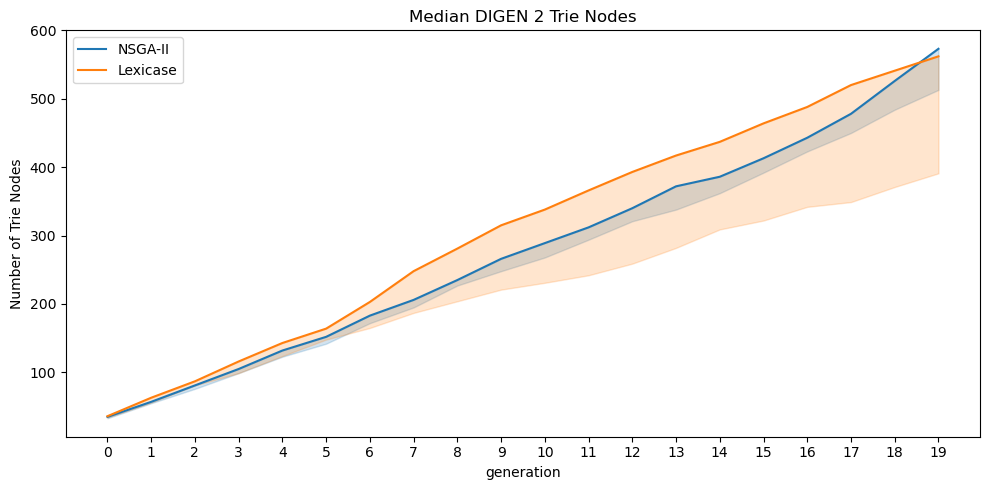

/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["value"] = df["value"].astype(float)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


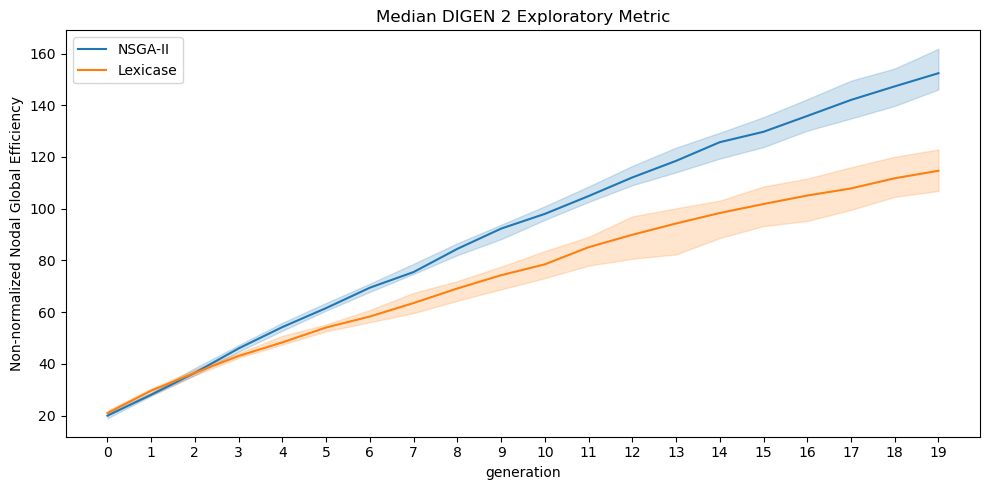

/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["value"] = df["value"].astype(float)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


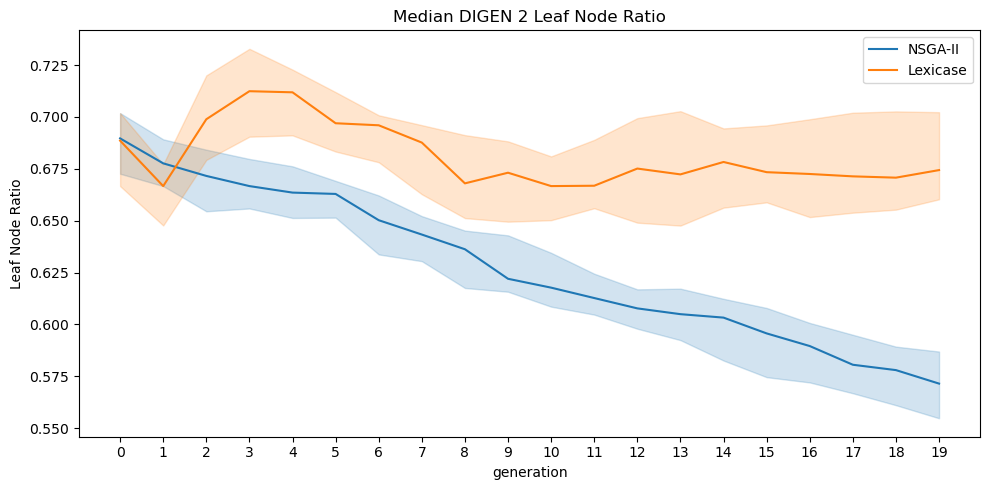

/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

4


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

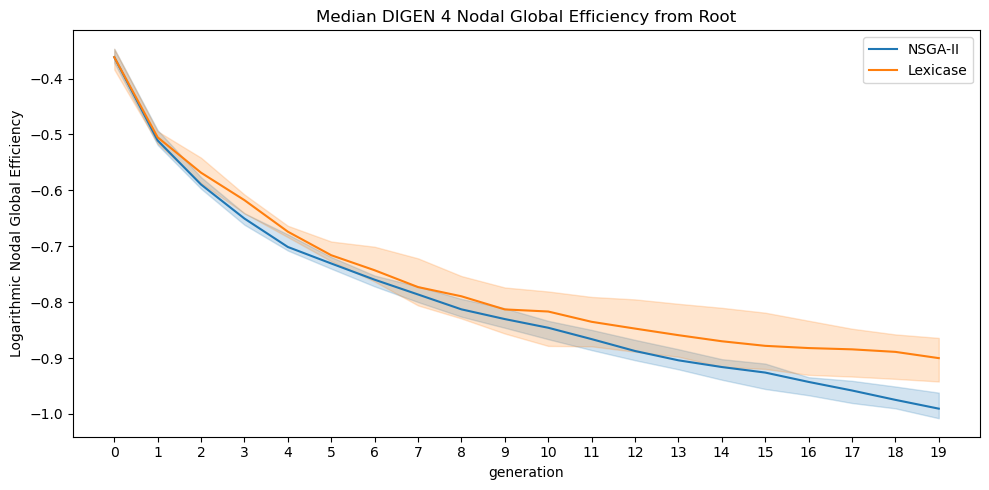

/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["value"] = df["value"].astype(int)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


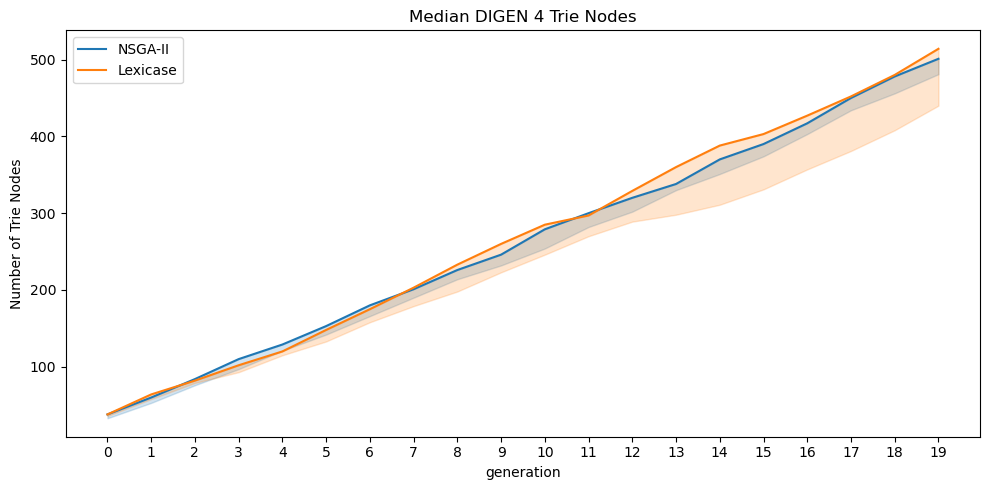

/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["value"] = df["value"].astype(float)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


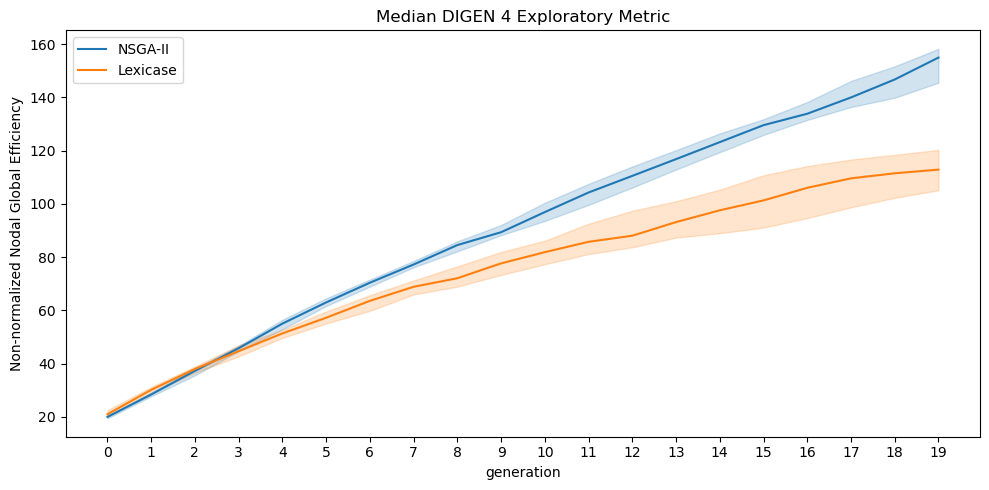

/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["value"] = df["value"].astype(float)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


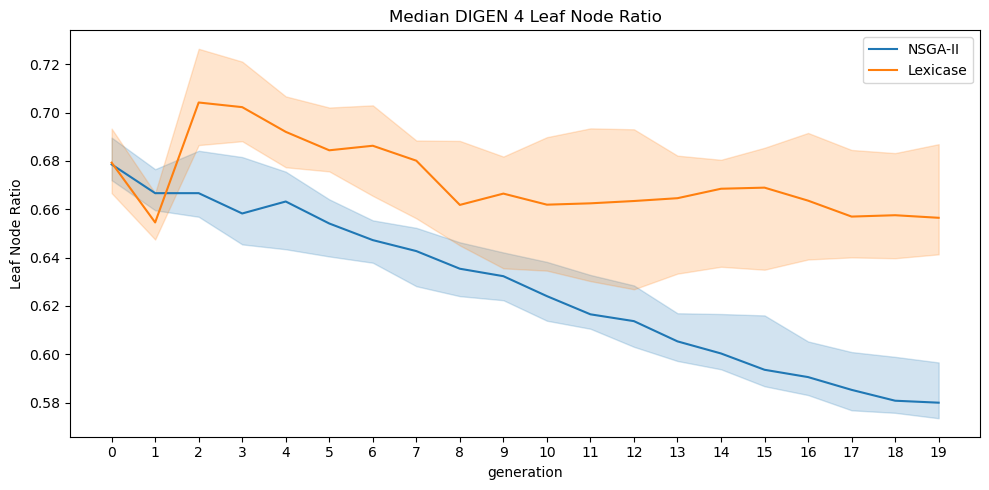

/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

24


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

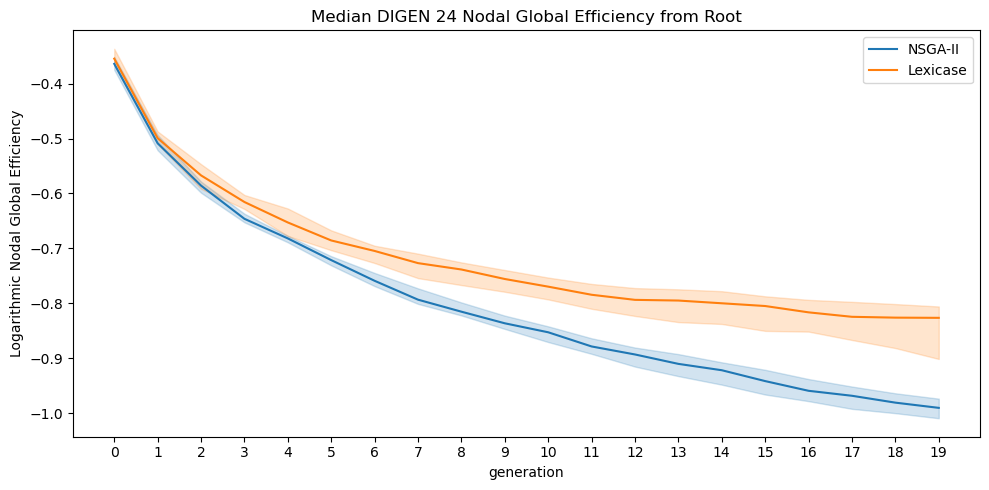

/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["value"] = df["value"].astype(int)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


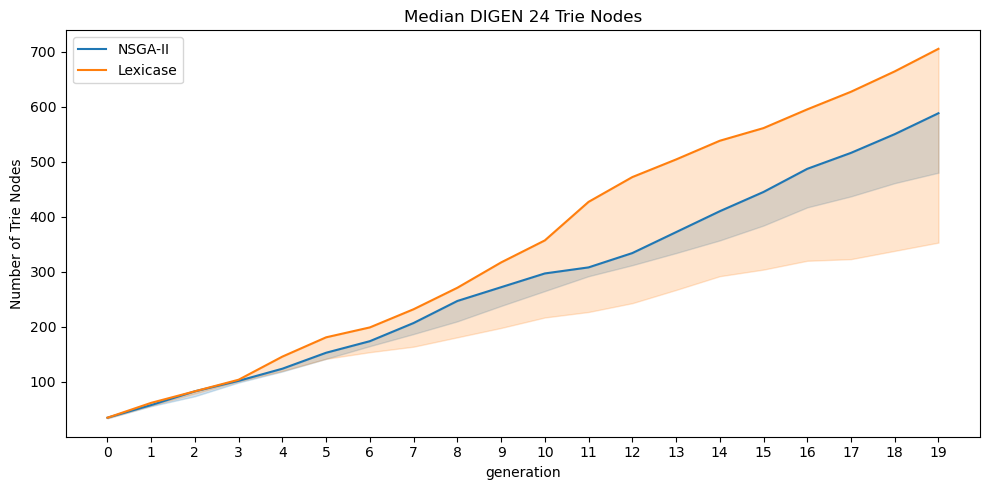

/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["value"] = df["value"].astype(float)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


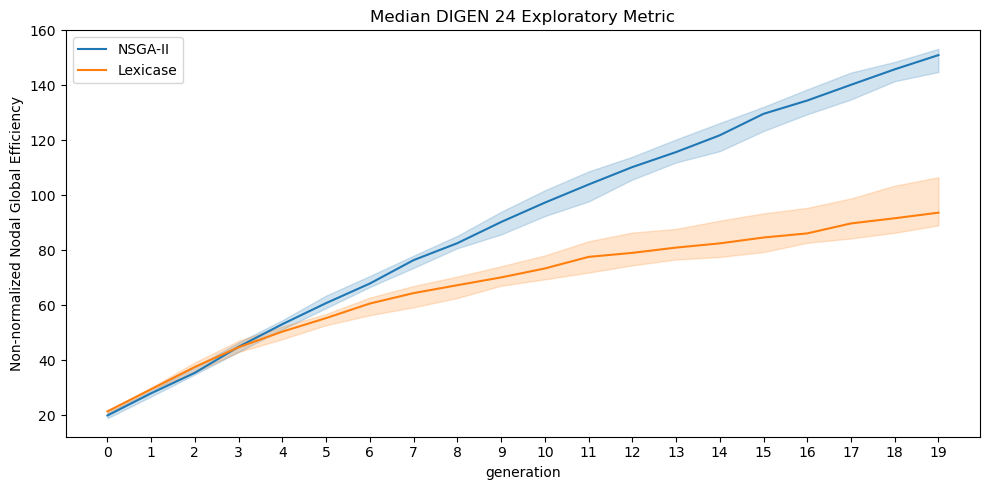

/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["value"] = df["value"].astype(float)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


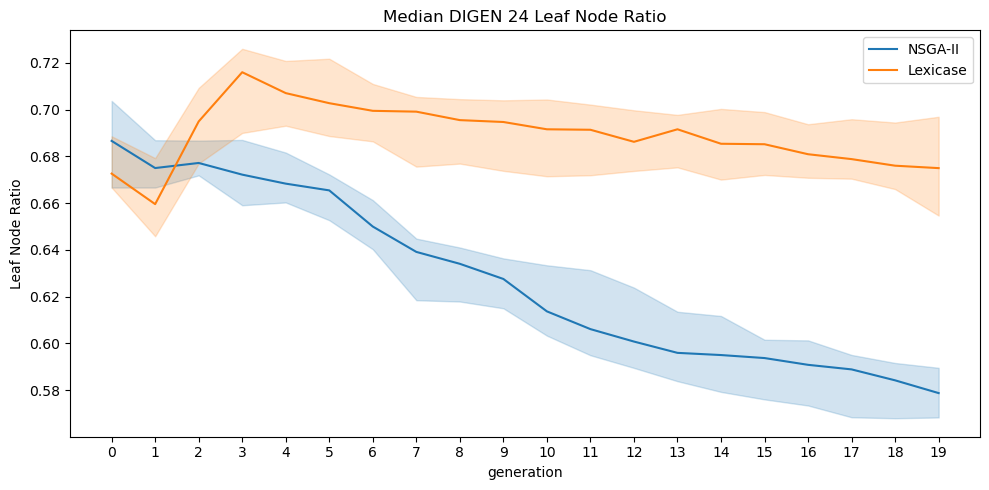

/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

28


/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fitness_df = fitness_df.append(fitness_df[2:3])
/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:64: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.co

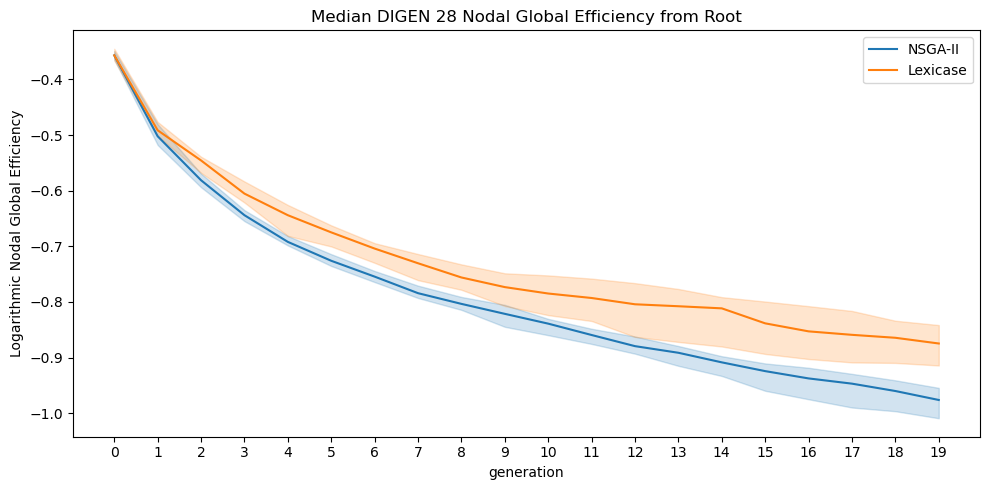

/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["value"] = df["value"].astype(int)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


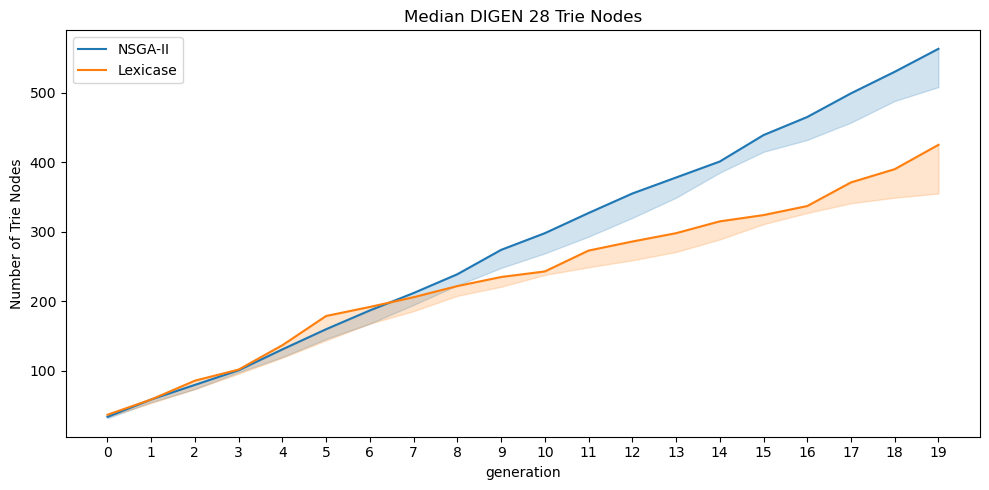

/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["value"] = df["value"].astype(float)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


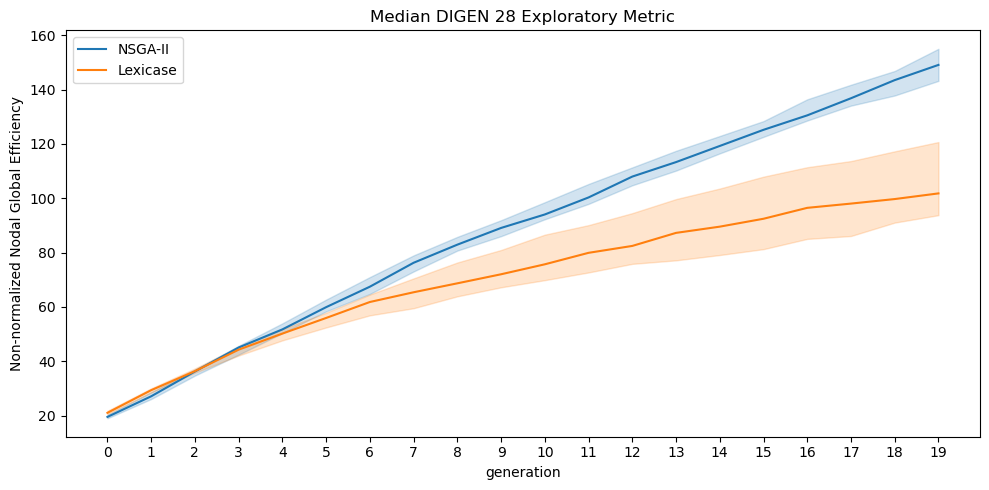

/var/folders/t2/2rb77zbx4fvdt47gjll69t9h0000gt/T/ipykernel_17463/3591152377.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["value"] = df["value"].astype(float)
/Users/matsumoton/opt/anaconda3/envs/tpot_env2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


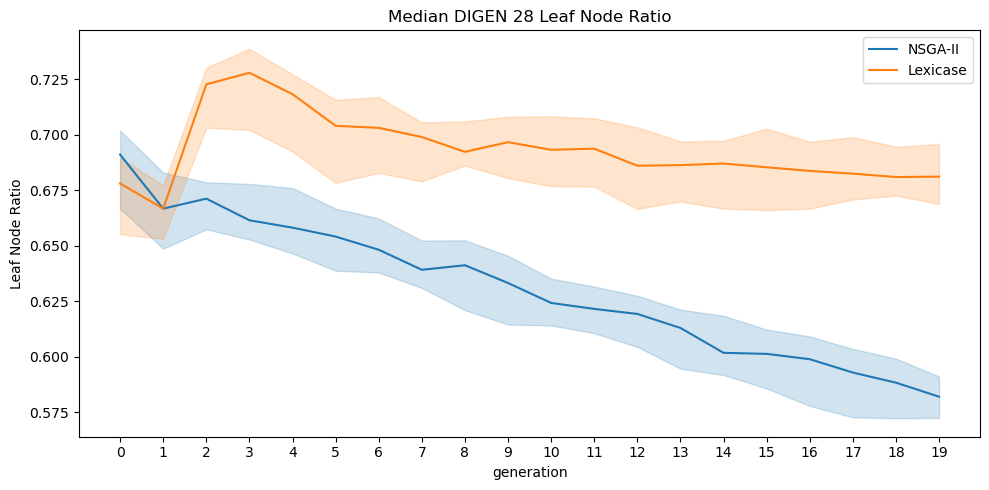

In [183]:
#DIGEN trie metric plots

import pandas as pd
from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import statistics

plt.rcParams["figure.figsize"] = (10,5)


directoryevs = ["/baseline_dynamic/baseline","/lexicase_dynamic/anges"]
#directoryevs = ["_baseline",""]

directoryevs = ["/baseline/baseline","/baseline_dynamic/baseline_dynamic","/lexicase/lexicase","/lexicase_dynamic/lexicase_dynamic"]
directoryevs = ["/baseline/baseline","/lexicase/lexicase"]
directoryevs = ["/baseline_gen100/baseline_gen100","/lexicase_gen100/lexicase_gen100","/autoepslexicase/autoepslexicase"]

upper_quantile_only = False

generation_num = 20
total_runs = 40

name_values = {
    "/baseline/baseline" : "baseline",
    "/baseline_dynamic/baseline_dynamic" : "baseline_dynamic",
    "/lexicase/lexicase" : "lexicase",
    "/lexicase_dynamic/lexicase_dynamic" : "lexicase_dynamic",
    "baseline_final" : "NSGA-II",
    "lexicase_final" : "Lexicase",
    "/selbest/selbest" : "selbest",
    "epsbestlex_final" : "Lexicase",
}

#key_times = [0,1,2,3,5,8,10,15,20,30,40,50 ] 

#key_times = [0,1,2,3,5,8,10,15,20,30,40,50,60,70,80,90,100 ]

directoryevs = ["baseline_final","lexicase_final","dynamic_final","lexicase_dynamic_final"]
directoryevs = ["baseline_final","epsbestlex_final"]


    

#for j in [2,4,7,14,23,24,25,27,28,30,32,35,40]:
for j in [2,4,24,28]:
    print(j)
    ev = []
    for directoryev in directoryevs:
        temp_ev = [] 
        for i in range(total_runs):
            ev_df_name = f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/digen/results_pop40_gen20_{directoryev}/pipelines/digen{j}_run_{i}_metrics.csv"
            #ev_df_name = f"/Users/matsumoton/pareto/anges{directoryev}_{i}_pareto_fitness.csv"
            #ev_df_name = f"/Users/matsumoton/Git/results_pop40_gen20_{directoryev}/pareto_fitnesses/digen{j}_run_{i}_evolution_pop40_gen20.csv"
            if not exists(ev_df_name):
                continue
            fitness_df = pd.read_csv(ev_df_name, sep=',')
            fitness_df = fitness_df[~fitness_df.isin([np.nan, np.inf, -np.inf]).any(1)]
            fitness_df = fitness_df.append(fitness_df[2:3])
            fitness_df.iloc[[5],[0]] = "adjusted_ge"
            fitness_df.iloc[[5],1:] = fitness_df.iloc[[2],1:].astype(float) / fitness_df.iloc[[0],1:].astype(float).values

            fitness_df = fitness_df.append(fitness_df[2:3])
            fitness_df.iloc[[6],[0]] = "leaf_node_ratio"
            fitness_df.iloc[[6],1:] = fitness_df.iloc[[3],1:].astype(float) / fitness_df.iloc[[0],1:].astype(float).values

            fitness_df = fitness_df.reset_index()
            temp_ev.append(fitness_df.iloc[[0,1,2,3,5,6]])

        temp_ev = pd.concat(temp_ev)
        temp_ev["type"] = name_values[directoryev]
        
        #temp_ev["score_diff"] = abs(temp_ev["cv_score"]-temp_ev["holdout_score"])
        ev.append(temp_ev)

    frame_df = pd.concat(ev)
    frame_df = frame_df.drop('index',axis=1)
    frame_df = frame_df.rename(columns={'Unnamed: 0': 'score'})
    frame_df = (frame_df.melt(['score','type'], var_name='generation')
            #.assign(Date = lambda x: pd.to_datetime(x['Date'], format='%d.%m.%Y'))
            .reset_index()
            )

    frame_df = frame_df[frame_df["type"].isin(['NSGA-II','Lexicase','Automatic Epsilon Lexicase'])]
    #frame_df = frame_df[frame_df["generation"].astype(int).isin(key_times)]

    df = frame_df[frame_df["score"] == "adjusted_ge"]

    df["value"] = df["value"].astype(float)
    df["log_value"] = np.log(df["value"])
    seaborn.lineplot(x="generation",y="log_value",hue="type",data=df, 
    #errorbar="sd",
    estimator=np.median,label = "type" if i == 0 else "").set(title="Median DIGEN "+str(j)+" Nodal Global Efficiency from Root")
    plt.ylabel("Logarithmic Nodal Global Efficiency")
    plt.gca().legend().set_title('')

    plt.savefig(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/final_plots/digen{j}_pareto_median_nodal_global_eff.png")

    plt.show()
    df = frame_df[frame_df["score"] == "unique_nodes"]
    df["value"] = df["value"].astype(int)
    seaborn.lineplot(x="generation",y="value",hue="type",data=df, 
    #errorbar="sd",
    estimator=np.max,label = "type" if i == 0 else "").set(title="Median DIGEN "+str(j)+" Trie Nodes")
    plt.ylabel("Number of Trie Nodes")
    plt.gca().legend().set_title('')
    plt.savefig(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/final_plots/digen{j}_pareto_median_trie_nodes.png")
    plt.show()

    df = frame_df[frame_df["score"] == "exploratory_metric"]
    df["value"] = df["value"].astype(float)
    seaborn.lineplot(x="generation",y="value",hue="type",data=df, 
    #errorbar="sd",
    estimator=np.median,label = "type" if i == 0 else "").set(title="Median DIGEN "+str(j)+" Exploratory Metric")
    plt.ylabel("Non-normalized Nodal Global Efficiency")
    plt.gca().legend().set_title('')
    plt.savefig(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/final_plots/digen{j}_pareto_median_exploratory_met.png")
    plt.show()

    df = frame_df[frame_df["score"] == "leaf_node_ratio"]
    df["value"] = df["value"].astype(float)
    seaborn.lineplot(x="generation",y="value",hue="type",data=df, 
    #errorbar="sd",
    estimator=np.median,label = "type" if i == 0 else "").set(title="Median DIGEN "+str(j)+" Leaf Node Ratio")
    plt.ylabel("Leaf Node Ratio")
    plt.gca().legend().set_title('')
    plt.savefig(f"/Users/matsumoton/Library/CloudStorage/Box-Box/tpot_benchmark_data/final_plots/digen{j}_pareto_median_leaf_node_ratio.png")
    plt.show()
